# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10. 

In [1]:
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
# сохраним полезную функцию отрисовки графиков в самом начале, чтобы не искать в блокноте
def make_plots(model, name='Test', save=False):
    fig = plt.figure(figsize=(15,5))
    fig.suptitle(name, fontsize=20)

    fig.add_subplot(121)
    plt.plot(model.history.history['loss'],'b--',label='train')
    plt.plot(model.history.history['val_loss'],'g-',label='validation')
    plt.legend(loc='best')
    plt.ylabel('loss')
    x_right_limit = len(model.history.history['loss'])
    tick = int((x_right_limit+1)/10)
    plt.xticks(range(0,x_right_limit+1,tick))
    plt.grid()
    plt.xlabel('epochs')
    plt.title('Loss_vs_epoch');

    fig.add_subplot(122)
    plt.plot(model.history.history['sparse_categorical_accuracy'],'b--',label='train')
    plt.plot(model.history.history['val_sparse_categorical_accuracy'],'g-',label='validation')
    plt.legend(loc='best')
    plt.ylabel('accuracy')
    plt.xticks(range(0,x_right_limit+1,tick))
    plt.grid()
    plt.xlabel('epochs')
    plt.title('Accuracy_vs_epoch');
    
    if save: fig.savefig(name)

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [4]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split

In [5]:
# Разбиваем на трейн валидационную и тестовую выборки:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

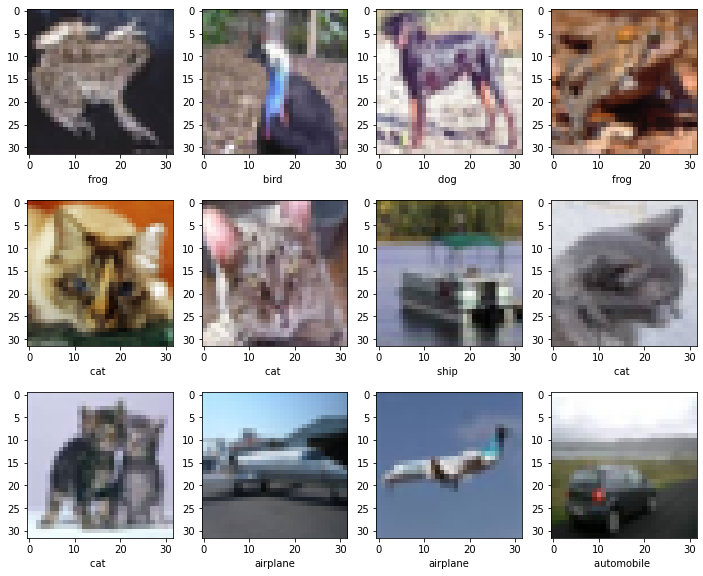

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [6]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [6]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [7]:
import keras
from keras import layers as L
from keras import backend as K

In [8]:
X_train.shape

(40000, 32, 32, 3)

In [9]:
inputs_0 = keras.Input(shape=X_train.shape[1:])

In [10]:
inputs_1 = keras.layers.Flatten()(inputs_0)

In [11]:
layer_2 = L.Dense(32,activation='relu')(inputs_1)

In [12]:
layer_3 = L.Dense(32,activation='softmax')(layer_2)

In [25]:
output = L.Dense(10,activation = tf.keras.activations.hard_sigmoid)(layer_3)

In [26]:
model = keras.Model(inputs = inputs_0, outputs = output, name = 'elementary_model' )

model.summary()

Model: "elementary_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                98336     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 99,722
Trainable params: 99,722
Non-trainable params: 0
_________________________________________________________________


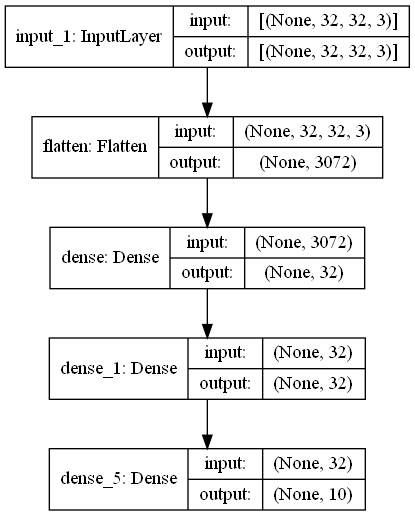

In [27]:
tf.keras.utils.plot_model(model,"elementary_model_shapes.png", show_shapes=True)

In [6]:
metrics = [
    keras.metrics.Accuracy(name='metric_accuracy'),
    keras.metrics.Precision(name='metric_precision'),
    keras.metrics.Recall(name='metric_recall'),
]

In [29]:
model.compile( loss = keras.losses.CategoricalCrossentropy(from_logits=False),
             optimizer=tf.keras.optimizers.Adam(),
                metrics=metrics
             )

In [7]:
y_train_labels = tf.keras.utils.to_categorical(y_train)
y_validation_labels = tf.keras.utils.to_categorical(y_val)

In [30]:
model.fit(
    X_train,
    y_train_labels,
    batch_size=50,
    epochs=10,
    verbose=2,
    validation_data=(X_val, y_validation_labels)
)

Epoch 1/10
800/800 - 3s - loss: 2.2278 - metric_accuracy: 0.0000e+00 - metric_precision: 0.1595 - metric_recall: 0.5900 - val_loss: 2.1572 - val_metric_accuracy: 0.0000e+00 - val_metric_precision: 0.1894 - val_metric_recall: 0.5720
Epoch 2/10
800/800 - 2s - loss: 2.0997 - metric_accuracy: 0.0000e+00 - metric_precision: 0.1968 - metric_recall: 0.5475 - val_loss: 2.0416 - val_metric_accuracy: 0.0000e+00 - val_metric_precision: 0.2056 - val_metric_recall: 0.4947
Epoch 3/10
800/800 - 2s - loss: 2.0005 - metric_accuracy: 0.0000e+00 - metric_precision: 0.2221 - metric_recall: 0.4215 - val_loss: 1.9725 - val_metric_accuracy: 0.0000e+00 - val_metric_precision: 0.2343 - val_metric_recall: 0.3746
Epoch 4/10
800/800 - 2s - loss: 1.9572 - metric_accuracy: 0.0000e+00 - metric_precision: 0.2507 - metric_recall: 0.3313 - val_loss: 1.9395 - val_metric_accuracy: 0.0000e+00 - val_metric_precision: 0.2572 - val_metric_recall: 0.3286
Epoch 5/10
800/800 - 2s - loss: 1.9376 - metric_accuracy: 0.0035 - metri

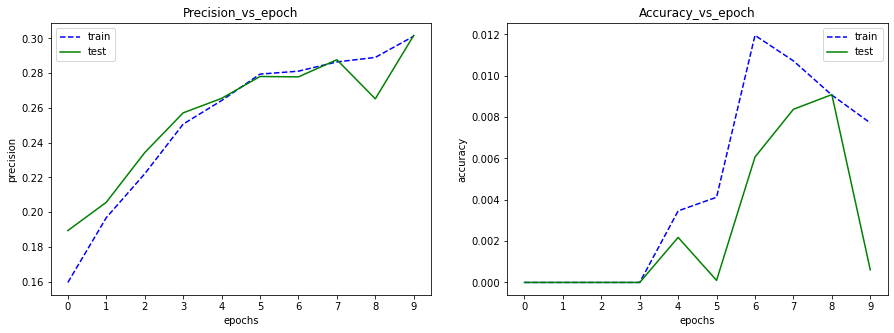

In [35]:
fig = plt.figure(figsize=(15,5))

fig.add_subplot(121)
plt.plot(model.history.history['metric_precision'],'b--',label='train')
plt.plot(model.history.history['val_metric_precision'],'g-',label='test')
plt.legend(loc='best')
plt.ylabel('precision')
plt.xticks(range(10))
plt.xlabel('epochs')
plt.title('Precision_vs_epoch');

fig.add_subplot(122)
plt.plot(model.history.history['metric_accuracy'],'b--',label='train')
plt.plot(model.history.history['val_metric_accuracy'],'g-',label='test')
plt.legend(loc='best')
plt.ylabel('accuracy')
plt.xticks(range(10))
plt.xlabel('epochs')
plt.title('Accuracy_vs_epoch');

### То же самое, только  в 'Sequental'

In [36]:
model_1_new = keras.Sequential([
    keras.Input(shape=X_train.shape[1:]),
    keras.layers.Flatten(),
    keras.layers.Dense(32,activation='relu'),
    keras.layers.Dense(32,activation='softmax'),
    keras.layers.Dense(10,activation = 'sigmoid')
])

In [37]:
model_1_new.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                98336     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
Total params: 99,722
Trainable params: 99,722
Non-trainable params: 0
_________________________________________________________________


In [38]:
model_1_new.compile(optimizer='RMSprop',
                   loss=tf.keras.losses.categorical_crossentropy, #'categorical_crossentropy'
                   metrics =metrics)

In [40]:
history = model_1_new.fit(X_train,
               y_train_labels,
               batch_size=32,
               epochs=10,
               validation_data=(X_val,y_validation_labels)
                         )

Epoch 1/10
1250/1250 [==============================] - 5s 3ms/step - loss: 2.1376 - metric_accuracy: 1.2200e-04 - metric_precision: 0.1689 - metric_recall: 0.6233 - val_loss: 2.0327 - val_metric_accuracy: 0.0000e+00 - val_metric_precision: 0.1955 - val_metric_recall: 0.6578
Epoch 2/10
1250/1250 [==============================] - 3s 3ms/step - loss: 1.9596 - metric_accuracy: 0.0000e+00 - metric_precision: 0.2166 - metric_recall: 0.6495 - val_loss: 1.9021 - val_metric_accuracy: 0.0000e+00 - val_metric_precision: 0.2380 - val_metric_recall: 0.6312
Epoch 3/10
1250/1250 [==============================] - 3s 3ms/step - loss: 1.8837 - metric_accuracy: 0.0000e+00 - metric_precision: 0.2411 - metric_recall: 0.6243 - val_loss: 1.8692 - val_metric_accuracy: 0.0000e+00 - val_metric_precision: 0.2493 - val_metric_recall: 0.6172
Epoch 4/10
1250/1250 [==============================] - 4s 3ms/step - loss: 1.8420 - metric_accuracy: 0.0000e+00 - metric_precision: 0.2593 - metric_recall: 0.6033 - val_lo

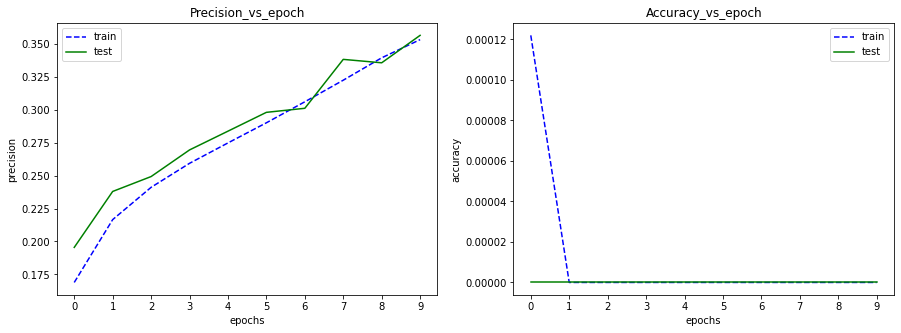

In [41]:
fig = plt.figure(figsize=(15,5))

fig.add_subplot(121)
plt.plot(model_1_new.history.history['metric_precision'],'b--',label='train')
plt.plot(model_1_new.history.history['val_metric_precision'],'g-',label='test')
plt.legend(loc='best')
plt.ylabel('precision')
plt.xticks(range(10))
plt.xlabel('epochs')
plt.title('Precision_vs_epoch');

fig.add_subplot(122)
plt.plot(model_1_new.history.history['metric_accuracy'],'b--',label='train')
plt.plot(model_1_new.history.history['val_metric_accuracy'],'g-',label='test')
plt.legend(loc='best')
plt.ylabel('accuracy')
plt.xticks(range(10))
plt.xlabel('epochs')
plt.title('Accuracy_vs_epoch');

In [42]:
a = model_1_new.predict(X_train[:20])
print('Результат предикт проба для перого элемента : ',a[0])
print('Максимальная вероятность для всех элеметов : ',np.argmax(a,axis=-1))
a_new = tf.keras.utils.to_categorical(np.argmax(a,axis=-1))
print('One-hot кодировка, для первого элемента: ',a_new[0] )
print('Результат sum(-1) после One-hot: ',a_new.sum(-1))


Результат предикт проба для перого элемента :  [0.10969627 0.17862436 0.2171098  0.3339017  0.11902106 0.32896754
 0.2808463  0.23461795 0.11105776 0.12040141]
Максимальная вероятность для всех элеметов :  [3 9 3 6 2 5 1 9 9 8 0 9 6 8 0 2 4 0 1 6]
One-hot кодировка, для первого элемента:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Результат sum(-1) после One-hot:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [43]:
dummy_pred = model_1_new.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(a_new.sum(-1), 1)
print("Успех!")

Успех!


In [44]:
# Сохраним модели:
model.save('Keras_model')
model_1_new.save('Keras_model_1_new')

INFO:tensorflow:Assets written to: Keras_model\assets
INFO:tensorflow:Assets written to: Keras_model_1_new\assets


In [45]:
del model, model_1_new

In [ ]:
# Пропустим шаг и загрузим модели из памяти:
model = keras.models.load_model("Keras_model")
model_1_new = keras.models.load_model("Keras_model_1_new")

## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [46]:
model_2 = keras.Sequential([
    keras.Input(shape=X_train.shape[1:]),
    keras.layers.Flatten(),
    keras.layers.Dense(100,activation='relu'),
    keras.layers.Dense(200,activation='sigmoid'),
    keras.layers.Dense(300,activation='relu'),
    keras.layers.Dense(10,activation = 'sigmoid')
])

In [ ]:
callbacks_best = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:03d}-loss_{val_loss:.2f}-acc_{sparse_categorical_accuracy:.3f}.h5',
        save_best_only=True,
        monitor='sparse_categorical_accuracy',
        mode='max')
]

In [ ]:
def learning_rate_decreaser(epoch,lr):
    l = -3/50
    if epoch < 25: 
        return lr
    else: 
        return lr*np.exp(l*epoch)

In [47]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        min_delta=1e-7,
        patience=30,
        mode='max', 
        restore_best_weights=False),
    
    tf.keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/' ,
        histogram_freq = 1,
        write_graph = False,
        write_images = False,
        write_steps_per_second = False,
        update_freq = 'epoch',
        profile_batch = 2,
        embeddings_freq = 1),
    
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./saved_models/model_2.{epoch:03d}-acc_{val_sparse_categorical_accuracy:.3f}.h5',
        save_best_only=True,
        monitor='val_sparse_categorical_accuracy',
        mode='max'),
    
    #tf.keras.callbacks.LearningRateScheduler(learning_rate_decreaser)
]

In [48]:
model_2.compile(optimizer=tf.optimizers.SGD(),
                   loss='sparse_categorical_crossentropy',
                   metrics ='sparse_categorical_accuracy')

In [187]:
X_val.shape,y_val.shape, X_train.shape,y_train.shape, 

((10000, 32, 32, 3), (10000, 1), (40000, 32, 32, 3), (40000, 1))

In [49]:
history = model_2.fit(X_train,
               y_train,
               batch_size=32,
               epochs=50,
               callbacks= callbacks,
               verbose =1,
               validation_data=(X_val,y_val) )             

Epoch 1/50
1250/1250 [==============================] - 7s 5ms/step - loss: 2.1159 - sparse_categorical_accuracy: 0.2264 - val_loss: 1.9658 - val_sparse_categorical_accuracy: 0.2866
Epoch 2/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.9108 - sparse_categorical_accuracy: 0.3140 - val_loss: 1.8578 - val_sparse_categorical_accuracy: 0.3377
Epoch 3/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.8291 - sparse_categorical_accuracy: 0.3448 - val_loss: 1.7866 - val_sparse_categorical_accuracy: 0.3641
Epoch 4/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.7651 - sparse_categorical_accuracy: 0.3677 - val_loss: 1.7280 - val_sparse_categorical_accuracy: 0.3795
Epoch 5/50
1250/1250 [==============================] - 7s 5ms/step - loss: 1.7109 - sparse_categorical_accuracy: 0.3889 - val_loss: 1.7241 - val_sparse_categorical_accuracy: 0.3815
Epoch 6/50
1250/1250 [==============================] - 7s 6ms/step - loss: 1.6694 - spars

Epoch 46/50
1250/1250 [==============================] - 7s 6ms/step - loss: 1.1498 - sparse_categorical_accuracy: 0.5906 - val_loss: 1.3837 - val_sparse_categorical_accuracy: 0.5131
Epoch 47/50
1250/1250 [==============================] - 7s 5ms/step - loss: 1.1467 - sparse_categorical_accuracy: 0.5910 - val_loss: 1.4149 - val_sparse_categorical_accuracy: 0.5067
Epoch 48/50
1250/1250 [==============================] - 7s 5ms/step - loss: 1.1373 - sparse_categorical_accuracy: 0.5934 - val_loss: 1.3657 - val_sparse_categorical_accuracy: 0.5165
Epoch 49/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.1292 - sparse_categorical_accuracy: 0.5990 - val_loss: 1.3626 - val_sparse_categorical_accuracy: 0.5210
Epoch 50/50
1250/1250 [==============================] - 7s 6ms/step - loss: 1.1223 - sparse_categorical_accuracy: 0.5992 - val_loss: 1.3613 - val_sparse_categorical_accuracy: 0.5285


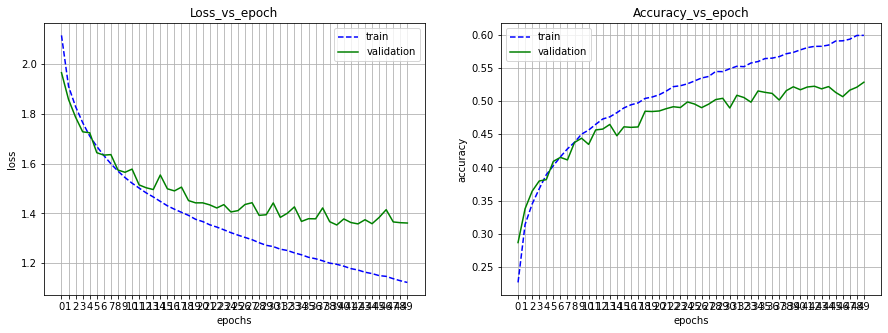

In [50]:
fig = plt.figure(figsize=(15,5))

fig.add_subplot(121)
plt.plot(model_2.history.history['loss'],'b--',label='train')
plt.plot(model_2.history.history['val_loss'],'g-',label='validation')
plt.legend(loc='best')
plt.ylabel('loss')
plt.xticks(range(0,50,5))
plt.grid()
plt.xlabel('epochs')
plt.title('Loss_vs_epoch');

fig.add_subplot(122)
plt.plot(model_2.history.history['sparse_categorical_accuracy'],'b--',label='train')
plt.plot(model_2.history.history['val_sparse_categorical_accuracy'],'g-',label='validation')
plt.legend(loc='best')
plt.ylabel('accuracy')
plt.xticks(range(0,50,5))
plt.grid()
plt.xlabel('epochs')
plt.title('Accuracy_vs_epoch');

По графику видно: кривая validation loss еще не начала расти в то время как кривая train loss максимально оптиизируется.  

Вывод:  
Обучать далее еще можно

In [51]:
a= np.max(model_2.history.history['val_sparse_categorical_accuracy'])
!telegram-send {a}
print('Самаая высокая Accuracy = ',format(a ))

Самаая высокая Accuracy =  0.5285000205039978


А теперь можно проверить качество вашей сети, выполнив код ниже:

In [52]:
from sklearn.metrics import accuracy_score

In [53]:
# Проверка:
y_pred = np.argmax(model_2.predict(X_test),axis=1).reshape(-1,1)
test_acc = accuracy_score(y_test, y_pred)
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


 Test_acc = 0.5266
 Not bad!


In [55]:
# Сохраним модели:
model_2.save('Keras_model_2')

INFO:tensorflow:Assets written to: Keras_model_2\assets


In [56]:
del model_2

In [57]:
# Загрузим модели из памяти:
model_2 = keras.models.load_model("Keras_model_2/")

## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [58]:
model_3 = keras.Sequential([
    keras.layers.Conv2D(
        filters=10,
        kernel_size=(3, 3),
        activation='relu',
        padding='valid',
        input_shape=X_train.shape[1:]),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    keras.layers.Flatten(),
    keras.layers.Dense(100,activation='relu'),
    keras.layers.Dense(10,activation='softmax')
])

In [59]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        min_delta=1e-5,
        patience=30,
        mode='max'),
    
    tf.keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/1/' ,
        histogram_freq = 1,
        update_freq = 'epoch',
        profile_batch = 2),
    
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./saved_models/model_3.{epoch:03d}-acc_{val_sparse_categorical_accuracy:.3f}.h5',
        save_best_only=True,
        monitor='sparse_categorical_accuracy',
        mode='max') 
]

In [63]:
model_3.compile(optimizer='Adam',
                   loss='sparse_categorical_crossentropy',
                   metrics ='sparse_categorical_accuracy')

In [64]:
history = model_3.fit(X_train,
               y_train,
               batch_size=32,
               epochs=50,
               callbacks= callbacks,
               verbose =2,
               validation_data=(X_val,y_val) )

Epoch 1/50
1250/1250 - 18s - loss: 1.5938 - sparse_categorical_accuracy: 0.4320 - val_loss: 1.4227 - val_sparse_categorical_accuracy: 0.4975
Epoch 2/50
1250/1250 - 17s - loss: 1.3164 - sparse_categorical_accuracy: 0.5350 - val_loss: 1.2811 - val_sparse_categorical_accuracy: 0.5439
Epoch 3/50
1250/1250 - 18s - loss: 1.2226 - sparse_categorical_accuracy: 0.5691 - val_loss: 1.2814 - val_sparse_categorical_accuracy: 0.5470
Epoch 4/50
1250/1250 - 19s - loss: 1.1568 - sparse_categorical_accuracy: 0.5936 - val_loss: 1.2553 - val_sparse_categorical_accuracy: 0.5643
Epoch 5/50
1250/1250 - 18s - loss: 1.1027 - sparse_categorical_accuracy: 0.6126 - val_loss: 1.2000 - val_sparse_categorical_accuracy: 0.5834
Epoch 6/50
1250/1250 - 18s - loss: 1.0543 - sparse_categorical_accuracy: 0.6301 - val_loss: 1.1926 - val_sparse_categorical_accuracy: 0.5864
Epoch 7/50
1250/1250 - 18s - loss: 1.0153 - sparse_categorical_accuracy: 0.6468 - val_loss: 1.1654 - val_sparse_categorical_accuracy: 0.5973
Epoch 8/50
12

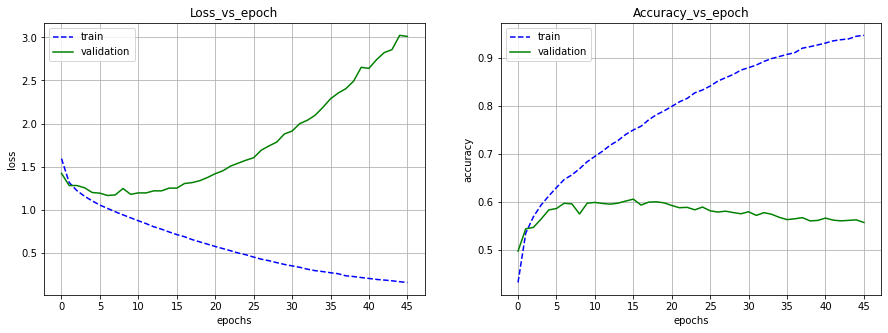

In [65]:
fig = plt.figure(figsize=(15,5))

fig.add_subplot(121)
plt.plot(model_3.history.history['loss'],'b--',label='train')
plt.plot(model_3.history.history['val_loss'],'g-',label='validation')
plt.legend(loc='best')
plt.ylabel('loss')
plt.xticks(range(0,50,5))
plt.grid()
plt.xlabel('epochs')
plt.title('Loss_vs_epoch');

fig.add_subplot(122)
plt.plot(model_3.history.history['sparse_categorical_accuracy'],'b--',label='train')
plt.plot(model_3.history.history['val_sparse_categorical_accuracy'],'g-',label='validation')
plt.legend(loc='best')
plt.ylabel('accuracy')
plt.xticks(range(0,50,5))
plt.grid()
plt.xlabel('epochs')
plt.title('Accuracy_vs_epoch');

По графику видно:  
кривая validation loss на 15 шаге начала расти (лосс по validation - достиг минимального значения), в то время как кривая train loss максимально оптиизируется. 

Вывод:  
после 15 шага - переобучение  
Обучать можно было до 15 шага.

Самая высокая accuracy:

In [67]:
a= np.max(model_3.history.history['val_sparse_categorical_accuracy'])
!telegram-send {a}
print('Самаая высокая Accuracy = ',format(a ))

Самаая высокая Accuracy =  0.60589998960495


In [68]:
model_3 = keras.models.load_model('./saved_models/model_3.015-acc_0.602.h5')

In [69]:
# Сохраним модель:
model_3.save('Keras_model_3')

INFO:tensorflow:Assets written to: Keras_model_3\assets


In [ ]:
del model_3

In [8]:
# Загрузим модели из памяти:
model_3 = keras.models.load_model("Keras_model_3/")

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [70]:
y_pred = np.argmax(model_3.predict(X_test),axis=1).reshape(-1,1)
test_acc = accuracy_score(y_test, y_pred)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


 Test_acc = 0.597
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций. 

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [152]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.sparse_categorical_crossentropy,
                 metrics=[keras.metrics.sparse_categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        
        # Если модель не является классом dict - то назначаем модели класс dict - 
        # а название модели пишем "single model"
        if not isinstance(models, dict):
            models = {'single_model': models}
        
        # Если 'optimizers' не является классом dict - то назначаем 'optimizers' класс dict - 
        # а название 'optimizers' пишем "optimizers.__class__"
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        
        super().__init__(
            [(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()]
        )
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
            
    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm(self):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='../TensorBoard_logs/logs/{}_{}'.format(model_name, optimizer_name))])
            
    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
            
        for model_name, model, optimizer_name, optimizer in tqdm(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='../TensorBoard_logs/logs/{}_{}'.format(model_name, optimizer_name))])
        
    def evaluate(self, X, y):
        for model_name, model, optimizer_name, _ in self:
            y_pred = np.argmax(model.predict(X_test),axis=1).reshape(-1,1)
            test_accuracy = accuracy_score(y_test, y_pred)
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name, test_accuracy ) )

In [75]:
models = {
    'model_2_1mln_params':model_2,
    'model_3_conv_pool':model_3
}

In [76]:
optimizers = {
    'SGD':tf.optimizers.SGD(),
    'Adam':tf.optimizers.Adam(),
    'Momentum':tf.keras.optimizers.RMSprop()
    # 'optimizer_name': optimizer
}

In [ ]:
evaluator = Evaluator(models=models, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))

In [130]:
# Сделаем функцию чтобы выводить результаты
from sklearn.metrics import confusion_matrix, classification_report
def report_results(evaluator_id=evaluator[0]):
    y_pred = np.argmax(evaluator_id[1].predict(X_test),axis=1).reshape(-1,1)
    test_accuracy = accuracy_score(y_test, y_pred)
    print('\t\t The model {}. \n\t\t( the best ({}) accuracy {})'.format(evaluator_id[0],evaluator_id[2],test_accuracy  ))
    print()
    print(classification_report(y_test,y_pred))

In [87]:
evaluator.evaluate(X_test, y_test)

Final score of model_2_1mln_params_SGD is 0.5118
Final score of model_2_1mln_params_Adam is 0.4337
Final score of model_2_1mln_params_Momentum is 0.393
Final score of model_3_conv_pool_SGD is 0.5699
Final score of model_3_conv_pool_Adam is 0.5386
Final score of model_3_conv_pool_Momentum is 0.5503


In [132]:
report_results(evaluator[0])
print()
report_results(evaluator[3])

		The model model_2_1mln_params. 
		( the best (SGD) accuracy 0.5118)

              precision    recall  f1-score   support

           0       0.51      0.68      0.58      1000
           1       0.63      0.64      0.63      1000
           2       0.44      0.36      0.39      1000
           3       0.39      0.27      0.32      1000
           4       0.37      0.54      0.44      1000
           5       0.50      0.29      0.37      1000
           6       0.49      0.66      0.56      1000
           7       0.54      0.64      0.58      1000
           8       0.66      0.62      0.64      1000
           9       0.68      0.42      0.52      1000

    accuracy                           0.51     10000
   macro avg       0.52      0.51      0.50     10000
weighted avg       0.52      0.51      0.50     10000

		The model model_3_conv_pool. 
		( the best (SGD) accuracy 0.5699)

              precision    recall  f1-score   support

           0       0.60      0.64      0.62   

In [151]:
for i,name in enumerate(class_names):print(i, name)

0 airplane
1 automobile 
2 bird 
3 cat 
4 deer 
5 dog 
6 frog 
7 horse 
8 ship 
9 truck


### Выводы:

- Самый лучший результат (сравнивались Adam, RMSprop и StochasticGD ):
    - для полносвязанных словев - SGD, второй место Adam
    - для свертки и полносвязанного слоя показал оптимизатор  SGD, (Adam переобучился - достаточно 15 эпох, а было 100) 
    
- Модель со сверткой (Conv2D) и пуллингом (MaxPooling2D) имея на 1/3 меньше параметров(по сравнению с моделью с полносвязанными слоями ) показывает лучше результат (при обработке изображения).
- Полносвязанный  и сверткочная модель лучше всего угадывают ship и automobile

Теперь используе функцию 'fit_generator' из класса evaluator.

Добавлю EarlyStop чтобы модель не переобучилась как до этого и проведу расчет только с лучшим оптимизатором - StochasticGD.

In [153]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        min_delta=1e-3,
        patience=2,
        mode='max')
    
]

In [154]:
models = {
    'model_2_1mln_params':model_2,
    'model_3_conv_pool':model_3
}

In [155]:
optimizers = {
    'SGD':tf.optimizers.SGD(),
}

In [158]:
#def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):

evaluator_2 = Evaluator(models=models, optimizers=optimizers)
evaluator_2.fit_generator(X_train, y_train, validation_data=(X_val, y_val),callbacks=callbacks )

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
1250/1250 [==============================] - 33s 26ms/step - loss: 2.1509 - sparse_categorical_accuracy: 0.2010 - val_loss: 2.0182 - val_sparse_categorical_accuracy: 0.2679
Epoch 2/100
1250/1250 [==============================] - 33s 27ms/step - loss: 2.0217 - sparse_categorical_accuracy: 0.2634 - val_loss: 1.9395 - val_sparse_categorical_accuracy: 0.2939
Epoch 3/100
1250/1250 [==============================] - 33s 26ms/step - loss: 1.9770 - sparse_categorical_accuracy: 0.2842 - val_loss: 1.8866 - val_sparse_categorical_accuracy: 0.3186
Epoch 4/100
1250/1250 [==============================] - 31s 25ms/step - loss: 1.9347 - sparse_categorical_accuracy: 0.2989 - val_loss: 1.8353 - val_sparse_categorical_accuracy: 0.3459
Epoch 5/100
1250/1250 [==============================] - 31s 25ms/step - loss: 1.9008 - sparse_categorical_accuracy: 0.3131 - val_loss: 1.7831 - val_sparse_categorical_accuracy: 0.3658
Epoch 6/100
1250/1250 [==============================] - 31s 25ms/step - lo

1250/1250 [==============================] - 38s 30ms/step - loss: 1.3617 - sparse_categorical_accuracy: 0.5145 - val_loss: 1.2418 - val_sparse_categorical_accuracy: 0.5648
Epoch 31/100
1250/1250 [==============================] - 38s 30ms/step - loss: 1.3594 - sparse_categorical_accuracy: 0.5114 - val_loss: 1.2295 - val_sparse_categorical_accuracy: 0.5651
Epoch 32/100
1250/1250 [==============================] - 38s 30ms/step - loss: 1.3526 - sparse_categorical_accuracy: 0.5167 - val_loss: 1.2402 - val_sparse_categorical_accuracy: 0.5546



### Результат 
Не самый хороший - по Early Stop остановось обучение:
- полносвязанной модели на 15 эпохе, с результатом 40% (без fit_generator 51%)
- сверточной модели на 32 эпохе, с результатом 55.5% (без fit_generator 56%)

### соберем свой Datagen:

In [11]:
# Создадим модель франкенштейн на базе сверкти(model_3) и обучим на поворотах изображения.
model_3_franki =keras.models.clone_model(model_3)

In [9]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    #featurewise_center = True, #нужно делать fit для генератора - иначе падает ядро
    #featurewise_std_normalization = True, # нужно делать fit для генератора - иначе падает ядро
    rotation_range = 20,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    brightness_range = [0.1,0.7],
    horizontal_flip = True,
    vertical_flip = True,
    data_format = 'channels_last')

In [21]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        min_delta=1e-5,
        patience=35,
        mode='max'),
    
    tf.keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/franki/' ,
        histogram_freq = 1,
        update_freq = 'epoch',
        profile_batch = 2),
    
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./saved_models/model_3_franki.{epoch:03d}-acc_{val_sparse_categorical_accuracy:.3f}.h5',
        save_best_only=True,
        monitor='sparse_categorical_accuracy',
        mode='max') 
]

In [12]:
model_3_franki.compile(optimizer = tf.keras.optimizers.SGD(), 
                       loss = tf.keras.losses.sparse_categorical_crossentropy, 
                       metrics = tf.keras.metrics.sparse_categorical_accuracy)

In [22]:
model_3_franki.fit( datagen.flow(X_train,y_train,batch_size=32),
    epochs=100,
    verbose=1,
    callbacks=callbacks,
    validation_data=datagen.flow(X_val,y_val,batch_size=32),
    shuffle=True,
    initial_epoch=0,
    #steps_per_epoch=2000,
    #validation_steps=800,
    validation_freq=1,
    workers=1,
    use_multiprocessing=False)

Epoch 1/100
1250/1250 [==============================] - 59s 47ms/step - loss: 2.1054 - sparse_categorical_accuracy: 0.2119 - val_loss: 2.1134 - val_sparse_categorical_accuracy: 0.2182
Epoch 2/100
1250/1250 [==============================] - 60s 48ms/step - loss: 2.1074 - sparse_categorical_accuracy: 0.2100 - val_loss: 2.1227 - val_sparse_categorical_accuracy: 0.2087
Epoch 3/100
1250/1250 [==============================] - 60s 48ms/step - loss: 2.1045 - sparse_categorical_accuracy: 0.2157 - val_loss: 2.0755 - val_sparse_categorical_accuracy: 0.2337
Epoch 4/100
1250/1250 [==============================] - 59s 47ms/step - loss: 2.1036 - sparse_categorical_accuracy: 0.2161 - val_loss: 2.1024 - val_sparse_categorical_accuracy: 0.2136
Epoch 5/100
1250/1250 [==============================] - 59s 47ms/step - loss: 2.0924 - sparse_categorical_accuracy: 0.2179 - val_loss: 2.1051 - val_sparse_categorical_accuracy: 0.2152
Epoch 6/100
1250/1250 [==============================] - 58s 47ms/step - lo

1250/1250 [==============================] - 57s 46ms/step - loss: 1.9345 - sparse_categorical_accuracy: 0.2924 - val_loss: 1.8786 - val_sparse_categorical_accuracy: 0.3160
Epoch 90/100
1250/1250 [==============================] - 57s 46ms/step - loss: 1.9326 - sparse_categorical_accuracy: 0.2921 - val_loss: 1.9138 - val_sparse_categorical_accuracy: 0.3083
Epoch 91/100
1250/1250 [==============================] - 57s 46ms/step - loss: 1.9272 - sparse_categorical_accuracy: 0.2961 - val_loss: 1.9027 - val_sparse_categorical_accuracy: 0.3039
Epoch 92/100
1250/1250 [==============================] - 57s 45ms/step - loss: 1.9247 - sparse_categorical_accuracy: 0.2966 - val_loss: 1.9089 - val_sparse_categorical_accuracy: 0.2952
Epoch 93/100
1250/1250 [==============================] - 57s 46ms/step - loss: 1.9312 - sparse_categorical_accuracy: 0.2938 - val_loss: 1.9850 - val_sparse_categorical_accuracy: 0.2606
Epoch 94/100
1250/1250 [==============================] - 57s 46ms/step - loss: 1.9

In [25]:
history = _

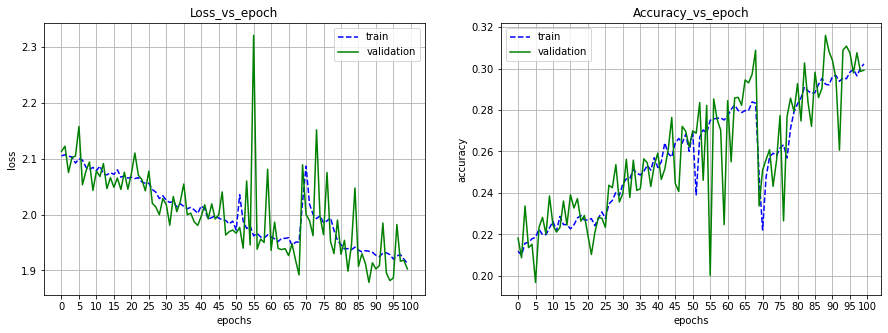

In [28]:
fig = plt.figure(figsize=(15,5))

fig.add_subplot(121)
plt.plot(model_3_franki.history.history['loss'],'b--',label='train')
plt.plot(model_3_franki.history.history['val_loss'],'g-',label='validation')
plt.legend(loc='best')
plt.ylabel('loss')
plt.xticks(range(0,101,5))
plt.grid()
plt.xlabel('epochs')
plt.title('Loss_vs_epoch');

fig.add_subplot(122)
plt.plot(model_3_franki.history.history['sparse_categorical_accuracy'],'b--',label='train')
plt.plot(model_3_franki.history.history['val_sparse_categorical_accuracy'],'g-',label='validation')
plt.legend(loc='best')
plt.ylabel('accuracy')
plt.xticks(range(0,101,5))
plt.grid()
plt.xlabel('epochs')
plt.title('Accuracy_vs_epoch');

Результат после 130 эпох:
- кривая loss имеет падающий тренд - это хорошо
- метрика точности имеет растущий тренд - то тоже хорошо
- Модель до сих пор обучается
- Даже не видно как расходятся линии train vs validation  - то значит модель еще будет долго обучаться.

In [29]:
model_3_franki.save('Keras_model_3_franki')

INFO:tensorflow:Assets written to: Keras_model_3_franki\assets


In [30]:
del model_3, model_3_franki

In [ ]:
# Загрузим модели из памяти:
model_3_franki = keras.models.load_model("model_3_franki/")

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

In [24]:
# Сначала сделаю новую модель
model_4 = keras.Sequential([
    keras.layers.Conv2D(
        filters=10,
        kernel_size=(3, 3),
        #activation='relu',
        padding='same',
        input_shape=X_train.shape[1:]),
    
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    keras.layers.Flatten(),
    keras.layers.Dense(100), #,activation='relu'),
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('relu'),                   
                       
    keras.layers.Dense(10,activation='softmax')
])

In [31]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        min_delta=1e-5,
        patience=35,
        mode='max'),
    
    tf.keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/normal/' ,
        histogram_freq = 1,
        update_freq = 'epoch',
        profile_batch = 2),
    
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./saved_models/model_4.{epoch:03d}-acc_{val_sparse_categorical_accuracy:.3f}.h5',
        save_best_only=True,
        monitor='sparse_categorical_accuracy',
        mode='max') 
]

In [32]:
model_4.compile(optimizer = tf.keras.optimizers.SGD(), 
                       loss = tf.keras.losses.sparse_categorical_crossentropy, 
                       metrics = tf.keras.metrics.sparse_categorical_accuracy)

In [ ]:
history = model_4.fit( X_train,y_train,batch_size=32,
            epochs=100,
            verbose=3,
            callbacks=callbacks,
            validation_data=(X_val,y_val),
            shuffle=True,
            initial_epoch=0);

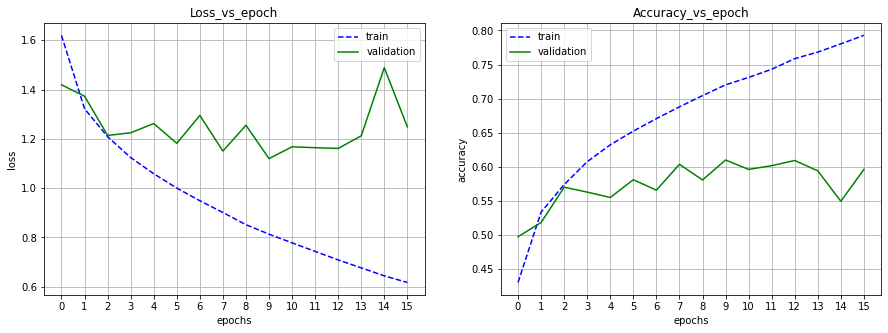

In [37]:
fig = plt.figure(figsize=(15,5))

fig.add_subplot(121)
plt.plot(model_4.history.history['loss'],'b--',label='train')
plt.plot(model_4.history.history['val_loss'],'g-',label='validation')
plt.legend(loc='best')
plt.ylabel('loss')
plt.xticks(range(0,16))
plt.grid()
plt.xlabel('epochs')
plt.title('Loss_vs_epoch');

fig.add_subplot(122)
plt.plot(model_4.history.history['sparse_categorical_accuracy'],'b--',label='train')
plt.plot(model_4.history.history['val_sparse_categorical_accuracy'],'g-',label='validation')
plt.legend(loc='best')
plt.ylabel('accuracy')
plt.xticks(range(0,16))
plt.grid()
plt.xlabel('epochs')
plt.title('Accuracy_vs_epoch');

### Вывод по нормализации: 
- Модель обучается заметно быстрее, 
- график (по сравнению с графиком model_3) мало чем отличается, за ислючением, что быстрее выходит на 'best efficiency point' другими словами - без нормализации best accuracy был на 15 эпохе, с нормализацией - на 9 эпохе.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [9]:
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)
        
    def add(self, layer):
        for name, model in self.items():
            model.add(layer)
            
    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})
        
    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Example of usage 
# models = Models(keras.Sequential())
# models.add(L.InputLayer(input_shape=(32, 32, 3)))
# models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
# models.add(L.MaxPooling2D())
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Activation('relu'))
# ...

In [46]:
del batch_normalisation_comparison

In [47]:
batch_normalisation_comparison = Models(tf.keras.Sequential())

In [48]:
batch_normalisation_comparison.add( tf.keras.Input(shape=X_train.shape[1:])  )

# Conv2D
batch_normalisation_comparison.add( tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3), padding='valid' )  )
batch_normalisation_comparison.add_create('Double_Conv_plus_norm', tf.keras.layers.BatchNormalization() ) 
batch_normalisation_comparison.add( tf.keras.layers.Activation('relu') )
batch_normalisation_comparison.add( tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='valid' ))

In [49]:
# one more Conv2D
batch_normalisation_comparison.add( tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3), padding='same'))
batch_normalisation_comparison.add_create('Double_Conv_plus_norm', tf.keras.layers.BatchNormalization() )
batch_normalisation_comparison.add( tf.keras.layers.Activation('relu') )
batch_normalisation_comparison.add( tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='valid' ))

#Flatten
batch_normalisation_comparison.add(tf.keras.layers.Flatten())

#Dense
batch_normalisation_comparison.add(keras.layers.Dense(100))
batch_normalisation_comparison.add( tf.keras.layers.BatchNormalization() )
batch_normalisation_comparison.add( tf.keras.layers.Activation('relu') )

#sigmoid
batch_normalisation_comparison.add(keras.layers.Dense(10))
batch_normalisation_comparison.add( tf.keras.layers.BatchNormalization() )
batch_normalisation_comparison.add( tf.keras.layers.Activation('sigmoid') )
batch_normalisation_comparison['Double_Conv_plus_norm'].summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 10)        280       
_________________________________________________________________
activation_12 (Activation)   (None, 30, 30, 10)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 10)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 10)        910       
_________________________________________________________________
batch_normalization_14 (Batc (None, 15, 15, 10)        40        
_________________________________________________________________
activation_13 (Activation)   (None, 15, 15, 10)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 10)         

In [63]:
batch_normalisation_comparison['base_model'].summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 10)        280       
_________________________________________________________________
activation_12 (Activation)   (None, 30, 30, 10)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 10)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 10)        910       
_________________________________________________________________
activation_13 (Activation)   (None, 15, 15, 10)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 10)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 490)              

In [72]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        min_delta=1e-5,
        patience=4,
        mode='max')]

In [ ]:
for name,model in batch_normalisation_comparison.items():
    model.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics = tf.keras.metrics.sparse_categorical_accuracy)
    
    
    new_callback = tf.keras.callbacks.TensorBoard(
            log_dir ='../TensorBoard_logs/{}/'.format(name) ,
            histogram_freq = 1,
            update_freq = 'epoch',
            profile_batch = 3)
    
    model.fit(X_train,y_train, batch_size = 32, epochs=30, verbose=3,
              validation_data=(X_val, y_val),
              callbacks = callbacks + [new_callback]            
    )

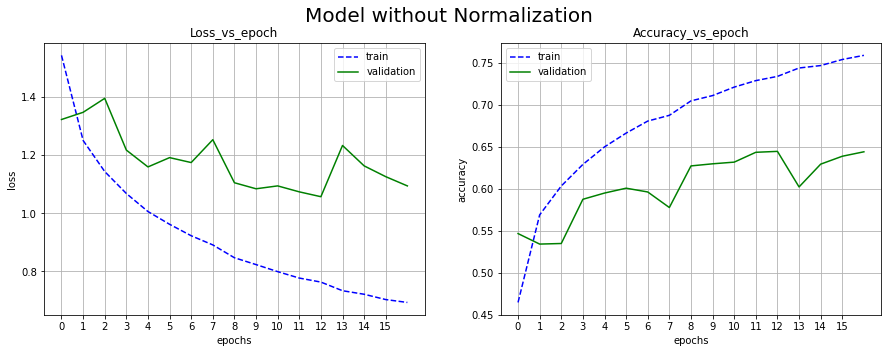

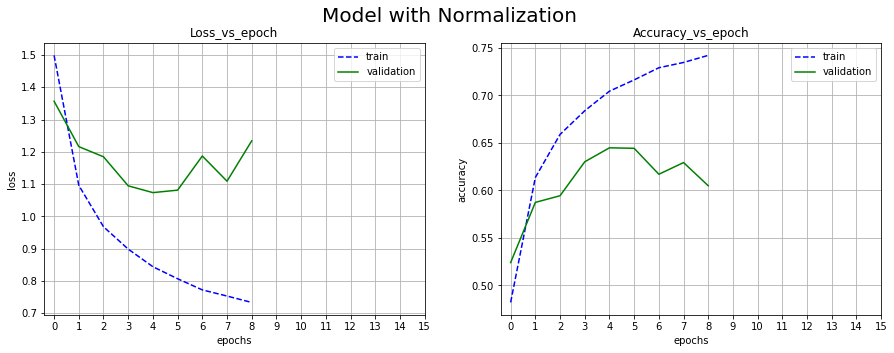

In [81]:
make_plots(model=batch_normalisation_comparison['base_model'],name='Model without Normalization')
make_plots(model=batch_normalisation_comparison['Double_Conv_plus_norm'],name='Model with Normalization')

#### Было сделано:
- два раза свертка Conv2D + maxPool2D
- растягивание
- полносвязаннй слой на 100 нейронов
- выходной слой на 10 нейронов

(!) - было создано 2 модели одна БЕЗ нормализации, вторая С нормализацией НА КАЖДОМ слое

#### Выводы:
- Модель С нормализацией достигла минимального loss на 4 эпохе, модель БЕЗ нормализации - на 12 эпохе
- Максимальная Accuracy:
    - модель С нормализацией .65 на 4 эпохе, 
    - модель БЕЗ нормализации - .65 на 12 эпохе

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

#### Решение 
Буду использовать модель С норализацией из предыдущего задания 

In [106]:
model_5 = keras.Sequential([
    keras.layers.Conv2D(
        filters = 10,
        kernel_size=(3, 3),
        padding='same',
        input_shape=X_train.shape[1:]),
    
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    
    keras.layers.Conv2D(
        filters = 10,
        kernel_size=(3, 3),
        padding='valid'),
    
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    keras.layers.Flatten(),
    
    #Dense 100 Relu
    keras.layers.Dense(100), 
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('relu'), 
    
    #Dense 100 Tanh
    keras.layers.Dense(100), 
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('tanh'), 
                       
    keras.layers.Dense(10,activation='sigmoid')
])

In [108]:
model_5.save_weights('model_5.h5')

In [85]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        min_delta=1e-5,
        patience=4,
        mode='max')]

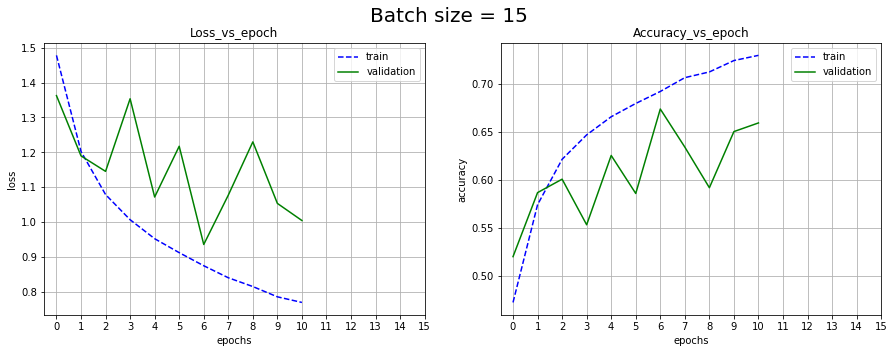

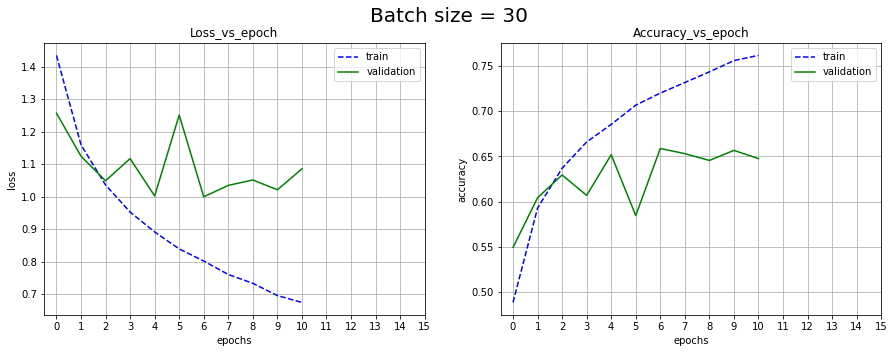

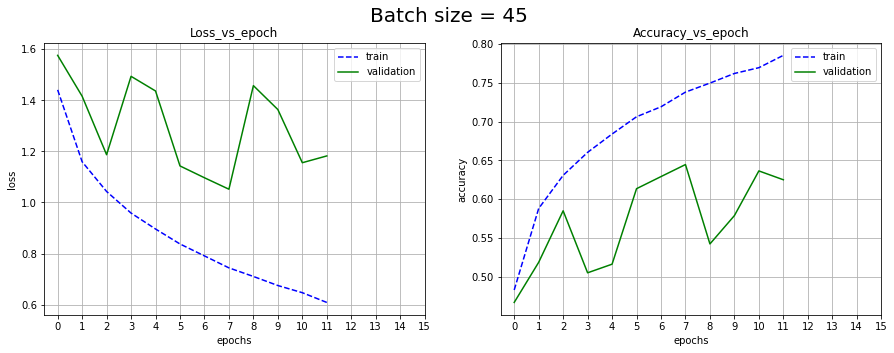

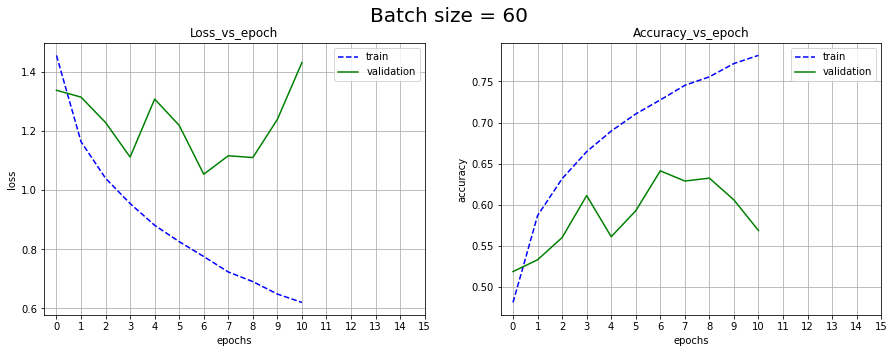

In [112]:
for new_batch_size in range(15,70,15):
    model_5.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics = tf.keras.metrics.sparse_categorical_accuracy)
    
    # Сбросим веса 
    model_5.load_weights('model_5.h5') 
    
    new_callback = tf.keras.callbacks.TensorBoard(
            log_dir ='../TensorBoard_logs/batch_size_{}/'.format(new_batch_size) ,
            histogram_freq = 1,
            update_freq = 'epoch',
            profile_batch = 3)
    
    history = model_5.fit(X_train,y_train, batch_size = new_batch_size, epochs=30, verbose=0,
              validation_data=(X_val, y_val),
              callbacks = callbacks + [new_callback] )
    
    make_plots( model=model_5,name='Batch size = {}'.format(new_batch_size) )
    

#### Выводы. С увеличением batch_size:
- модель начинает быстрее переучиваться  - плохо
- минимальный validation loss увеличивается - плохо
- максимальная validation accuracy уеньшается  - плохо

Идеальный batch_size = 15

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

В задании 1.5 я использовал модель c двумя слоями [conv2D(with normalization) + MaxPool2D] , 
так как данная модель показывает самый лучший результат по accuracy и loss.

А также провел сравнительный анализ по batch_size (в задании 1.5) чтобы определить наилучшую кривую обучения.

что понимаю под наилучшей кривой:  
Для начала введем понятие наилучшая точка обучения -когда loss на validation перестает падать и начинает расти, loss на train продолжает падать.  
Наилучшая кривая - когда наилучшая точка дает максиальную результативность (например наилучший показатель метрики accuracy)

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

#### модель с 30 фильтрами :

In [17]:
# модель с несколькими 30 фильтрами :
model_6 = keras.Sequential([
    keras.layers.Conv2D(
        filters = 30,
        kernel_size=(3, 3),
        padding='same',
        input_shape=X_train.shape[1:]),
    
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    
    keras.layers.Conv2D(
        filters = 30,
        kernel_size=(3, 3),
        padding='valid'),
    
    keras.layers.BatchNormalization(), #Добавим нормализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    keras.layers.Flatten(),
    
    #Dense 100 Relu
    keras.layers.Dense(100), 
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('relu'), 
    
    #Dense 100 Tanh
    keras.layers.Dense(100), 
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('tanh'), 
                       
    keras.layers.Dense(10,activation='sigmoid')
])

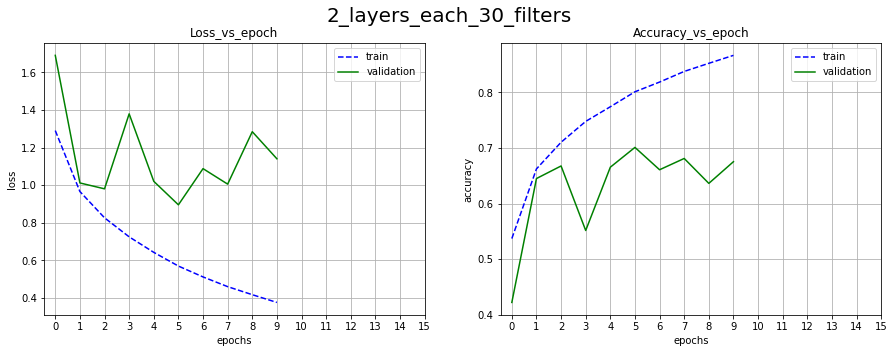

In [116]:
model_6.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics = tf.keras.metrics.sparse_categorical_accuracy)
    
    
new_callback = tf.keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/2layers_30filters/' ,
        histogram_freq = 1,
        update_freq = 'epoch',
        profile_batch = 3)

history = model_6.fit(X_train,y_train, batch_size = 30, epochs=30, verbose=0,
          validation_data=(X_val, y_val),
          callbacks = callbacks + [new_callback] )

make_plots( model=model_6,name='2_layers_each_30_filters')

#### Результат 30 фильтров :
- best accuracy = .7 и 
- обучение достигло best efficiency point на 5 эпохе
- minimum validation loss .9

#### модель с несколькими фильтрами и dilation_rate = (2,2):

In [101]:
# модель с несколькими фильтрами и dilation_rate = (2,2):
model_6 = keras.Sequential([
    keras.layers.Conv2D(
        filters = 30,
        kernel_size=(3, 3),
        padding='same',
        dilation_rate = (2,2),
        input_shape=X_train.shape[1:]),
    
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    
    keras.layers.Conv2D(
        filters = 30,
        kernel_size=(3, 3),
        padding='valid'),
    
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    keras.layers.Flatten(),
    
    #Dense 100 Relu
    keras.layers.Dense(100), 
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('relu'), 
    
    #Dense 100 Tanh
    keras.layers.Dense(100), 
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('tanh'), 
                       
    keras.layers.Dense(10,activation='sigmoid')
])

In [ ]:
model_6.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics = tf.keras.metrics.sparse_categorical_accuracy)
    
    
new_callback = tf.keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/30_filters/' ,
        histogram_freq = 1,
        update_freq = 'epoch',
        profile_batch = 3)

history = model_6.fit(X_train,y_train, batch_size = 30, epochs=30, verbose=0,
          validation_data=(X_val, y_val),
          callbacks = callbacks + [new_callback] )

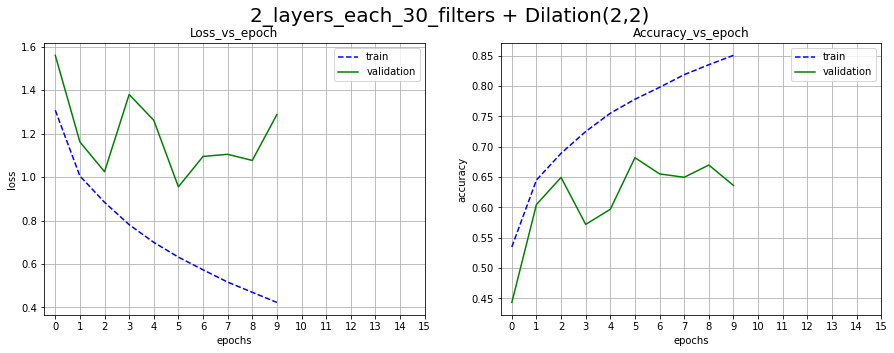

In [111]:
make_plots( model=model_6,name='2_layers_each_30_filters + Dilation(2,2)')

#### Результат 30 фильтров + Dilation(2,2):
- best accuracy = .67 и 
- обучение достигло best efficiency point на 5 эпохе
- minimum validation loss .97

Без Dilation выходило на 3% лучше

#### datagen

In [119]:
# модель с 30 фильтрами + datagen :
model_6 = keras.Sequential([
    keras.layers.Conv2D(
        filters = 30,
        kernel_size=(3, 3),
        padding='same',
        input_shape=X_train.shape[1:]),
    
    keras.layers.BatchNormalization(), #Добавим нормализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    
    keras.layers.Conv2D(
        filters = 30,
        kernel_size=(3, 3),
        padding='valid'),
    
    keras.layers.BatchNormalization(), #Добавим нормализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    keras.layers.Flatten(),
    
    #Dense 100 Relu
    keras.layers.Dense(100), 
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('relu'), 
    
    #Dense 100 Tanh
    keras.layers.Dense(100), 
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('tanh'), 
                       
    keras.layers.Dense(10,activation='sigmoid')
])

In [120]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    #featurewise_center = True, #нужно делать fit для генератора - иначе падает ядро
    #featurewise_std_normalization = True, # нужно делать fit для генератора - иначе падает ядро
    rotation_range = 50,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    brightness_range = [0.1,0.7],
    horizontal_flip = True,
    vertical_flip = True,
    data_format = 'channels_last')

In [21]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        min_delta=1e-5,
        patience=15,
        mode='max'),
    
    tf.keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/datagen_(50_03_03)/' ,
        histogram_freq = 1,
        update_freq = 'epoch',
        profile_batch = 2),

]

In [12]:
model_6.compile(optimizer = tf.keras.optimizers.SGD(), 
                       loss = tf.keras.losses.sparse_categorical_crossentropy, 
                       metrics = tf.keras.metrics.sparse_categorical_accuracy)

In [ ]:
model_6.fit( datagen.flow(X_train,y_train,batch_size=15),
    epochs=500,
    verbose=1,
    callbacks=callbacks,
    validation_data=datagen.flow(X_val,y_val,batch_size=15),
    shuffle=True,
    initial_epoch=0,
    #steps_per_epoch=2000,
    #validation_steps=800,
    validation_freq=1,
    workers=1,
    use_multiprocessing=False)

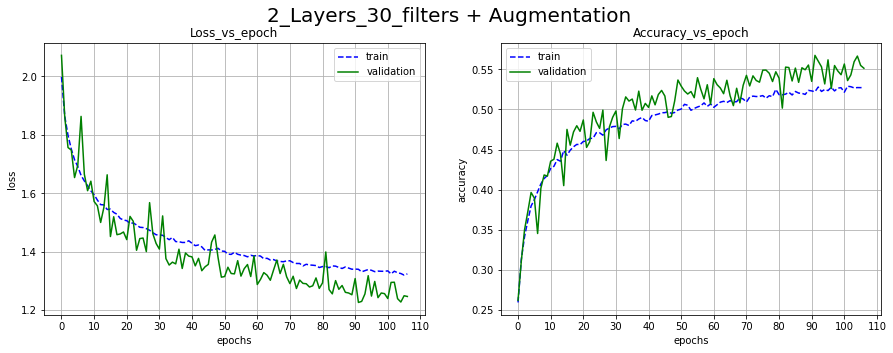

In [152]:
make_plots( model=model_6 ,name='2_Layers_30_filters + Augmentation')

#### Вывод по Augmentation:
- модель обучается очень долго - нужно 100 эпох чтобы снизить loss с 2 до 1.4 (обычная модель такой путь проходит за 2-3 эпохи.
- loss по validation ниже чем по train - это значит что модельь еще может оченьдолго обучаться ( до того момента пока  loss по train будет снижаться, loss по validation будет расти) 
- даже на текущий момент Accuracy На validation .55 что хорошо.

методику augmentation совершенно точно нужно включать в модель, но обучаться она должна как минимум день на collab, с правильно подобранными параметрами.

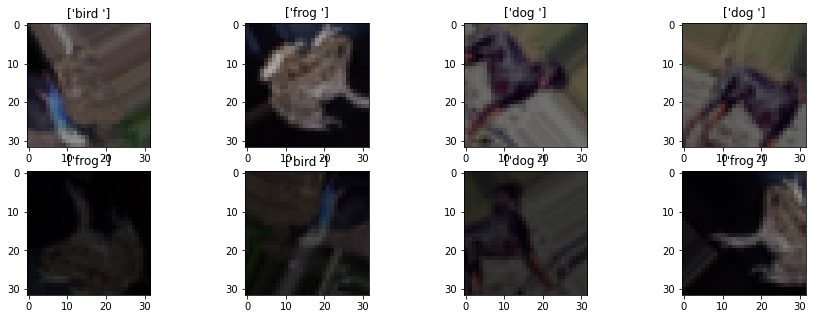

In [194]:
# проверим какие картинки мы скармливаем модели:
i=1
fig = plt.figure(figsize=(15,5))

for img,label in datagen.flow(X_train[:3],y_train[:3],batch_size=1):
    
    fig.add_subplot(240+i)
    i+=1
    
    plt.imshow(img[0]/255)
    plt.title(class_names[label][0])
    
    if i>8: break

Подберем необходимые параметры для augmentation.  

С такими параметрами будет обучаться финальная модель.

In [167]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    #featurewise_center = True, #нужно делать fit для генератора - иначе падает ядро
    #featurewise_std_normalization = True, # нужно делать fit для генератора - иначе падает ядро
    rotation_range =  30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range = [0.3,1],
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range=0.5,
    channel_shift_range=0.3,
    fill_mode='nearest', # чтобы модель упала => 'wrap'
    data_format = 'channels_last')

# проверим какие картинки мы скармливаем модели:
i=1
fig = plt.figure(figsize=(15,5))

for img,label in datagen.flow(X_train[:3],y_train[:3],batch_size=1):
    
    fig.add_subplot(240+i)
    i+=1
    
    plt.imshow(img[0]/255)
    plt.title(class_names[label][0])
    
    if i>8: break

TypeError: bad operand type for unary -: 'list'

<Figure size 1080x360 with 0 Axes>

#### модель с 30 фильтрами  и Dropout (.2):

In [122]:
# модель с 30 фильтрами :
model_6 = keras.Sequential([
    keras.layers.Conv2D(
        filters = 30,
        kernel_size=(3, 3),
        padding='same',
        input_shape=X_train.shape[1:]),
    
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    
    keras.layers.Conv2D(
        filters = 30,
        kernel_size=(3, 3),
        padding='valid'),
    
    keras.layers.BatchNormalization(), #Добавим нормализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    keras.layers.Flatten(),
    
    #Dense 100 Relu
    keras.layers.Dense(100),
    keras.layers.Dropout(.2),
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('relu'), 
    
    #Dense 100 Tanh
    keras.layers.Dense(100), 
    keras.layers.Dropout(.2),
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('tanh'), 
                       
    keras.layers.Dense(10,activation='sigmoid')
])

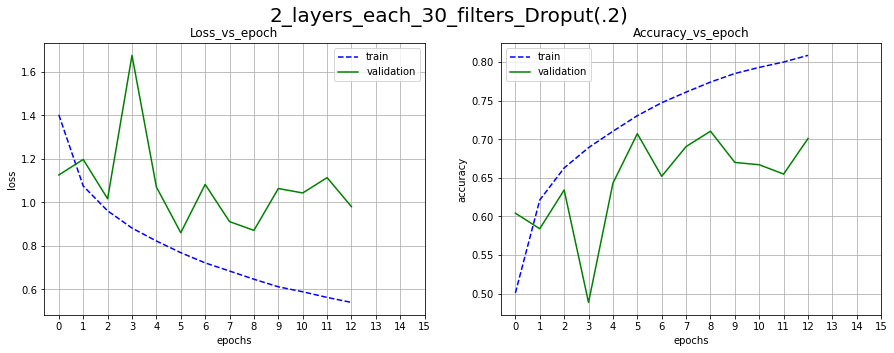

In [123]:
model_6.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics = tf.keras.metrics.sparse_categorical_accuracy)
    
    
new_callback = tf.keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/2layers_30filters_dropout/' ,
        histogram_freq = 1,
        update_freq = 'epoch',
        profile_batch = 3)

history = model_6.fit(X_train,y_train, batch_size = 30, epochs=30, verbose=0,
          validation_data=(X_val, y_val),
          callbacks = callbacks + [new_callback] )

make_plots( model=model_6,name='2_layers_each_30_filters_Droput(.2)')

#### Результат 30 фильтров и Dropout:
- best accuracy = .72 - максимум, который когда либо был - это хорошо
- обучение достигло best efficiency point на 5 и 8 эпохе
- minimum validation loss .85 - минимум который когда либо был - это хорошо

#### модель с 90 фильтрами :

In [125]:
# модель с 90 фильтрами :
model_6 = keras.Sequential([
    keras.layers.Conv2D(
        filters = 90,
        kernel_size=(3, 3),
        padding='same',
        input_shape=X_train.shape[1:]),
    
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    
    keras.layers.Conv2D(
        filters = 60,
        kernel_size=(3, 3),
        padding='valid'),
    
    keras.layers.BatchNormalization(), #Добавим нормализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    keras.layers.Flatten(),
    
    #Dense 100 Relu
    keras.layers.Dense(100),
    keras.layers.Dropout(.2),
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('relu'), 
    
    #Dense 100 Tanh
    keras.layers.Dense(100), 
    keras.layers.Dropout(.2),
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('tanh'), 
                       
    keras.layers.Dense(10,activation='sigmoid')
])

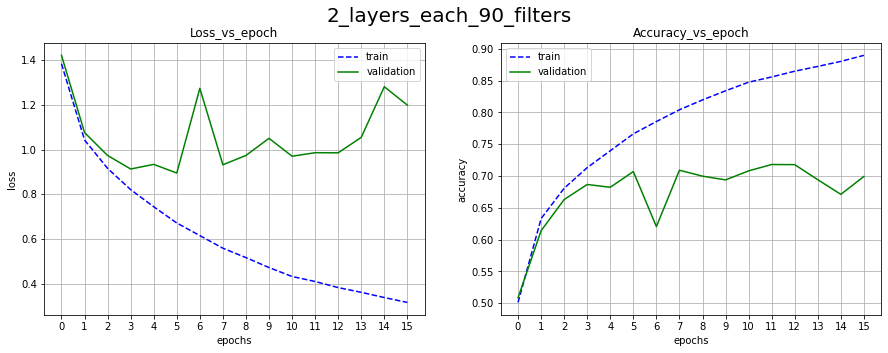

In [126]:
model_6.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics = tf.keras.metrics.sparse_categorical_accuracy)
    
    
new_callback = tf.keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/2layers_90filters/' ,
        histogram_freq = 1,
        update_freq = 'epoch',
        profile_batch = 3)

history = model_6.fit(X_train,y_train, batch_size = 30, epochs=30, verbose=0,
          validation_data=(X_val, y_val),
          callbacks = callbacks + [new_callback] )

make_plots( model=model_6,name='2_layers_each_90_filters')

#### Результат 90 фильтров :
- best accuracy = .72 на 11 эпохе - это хорошо
- обучение достигло best efficiency point на 11 эпохе
- minimum validation loss .85 на 4 эпохе, далее validation loss начал расти - модель склонна очень быстро переобучаться.

Можно увеличить количество фильтров до 60 но не более, чтобы исключить вероятность быстрого переобучения.

### Inception module

In [255]:
# модель с Inception module :

input_layer = keras.Input(shape=X_train.shape[1:])

#inception module:
layer_1_1 = keras.layers.Conv2D(filters=60, kernel_size=(1,1), padding='same')(input_layer)
layer_1_1 = keras.layers.BatchNormalization()(layer_1_1)
layer_1_1 = keras.layers.Activation('relu')(layer_1_1)

layer_1_2 = keras.layers.Conv2D(filters=60, kernel_size=(1,1), padding='same')(input_layer)
layer_1_2 = keras.layers.BatchNormalization()(layer_1_2)
layer_1_2 = keras.layers.Activation('relu')(layer_1_2)
layer_1_2 = keras.layers.Conv2D(filters=60, kernel_size=(3,3), padding='same',activation='relu')(layer_1_2)


layer_1_3 = keras.layers.Conv2D(filters=60, kernel_size=(1,1), padding='same')(input_layer)
layer_1_3 = keras.layers.BatchNormalization()(layer_1_3)
layer_1_3 = keras.layers.Activation('relu')(layer_1_3)
layer_1_3 = keras.layers.Conv2D(filters=60, kernel_size=(3,3), padding='same',activation='relu')(layer_1_3)
layer_1_3 = keras.layers.Conv2D(filters=60, kernel_size=(3,3), padding='same',activation='relu')(layer_1_3)

layer_1_4 = keras.layers.MaxPool2D(pool_size=(2,2),strides=(1,1), padding='same')(input_layer)
layer_1_4 = keras.layers.Conv2D(filters=60, kernel_size=(1,1), padding='same')(layer_1_4)
layer_1_4 = keras.layers.BatchNormalization()(layer_1_4)
layer_1_4 = keras.layers.Activation('relu')(layer_1_4)

layer_1_sum = keras.layers.concatenate( [layer_1_1, layer_1_2, layer_1_3, layer_1_4],axis=3 )

# Flat
layer_2_flat = keras.layers.Flatten()(layer_1_sum)

# Dense 100 ReLu
layer_3_dense_1 = keras.layers.Dense(100)(layer_2_flat)
layer_3_dense_1 = keras.layers.BatchNormalization()(layer_3_dense_1)
layer_3_dense_1 = keras.layers.Activation('relu')(layer_3_dense_1)

# Dense 100 tanh
layer_4_dense_2 = keras.layers.Dense(100)(layer_3_dense_1)
layer_4_dense_2 = keras.layers.BatchNormalization()(layer_4_dense_2)
layer_4_dense_2 = keras.layers.Activation('tanh')(layer_4_dense_2)

layer_5 = keras.layers.Dense(10,activation='sigmoid')(layer_4_dense_2)

model_6_inception = keras.Model(inputs = input_layer, outputs = layer_5, name = 'inception_model')

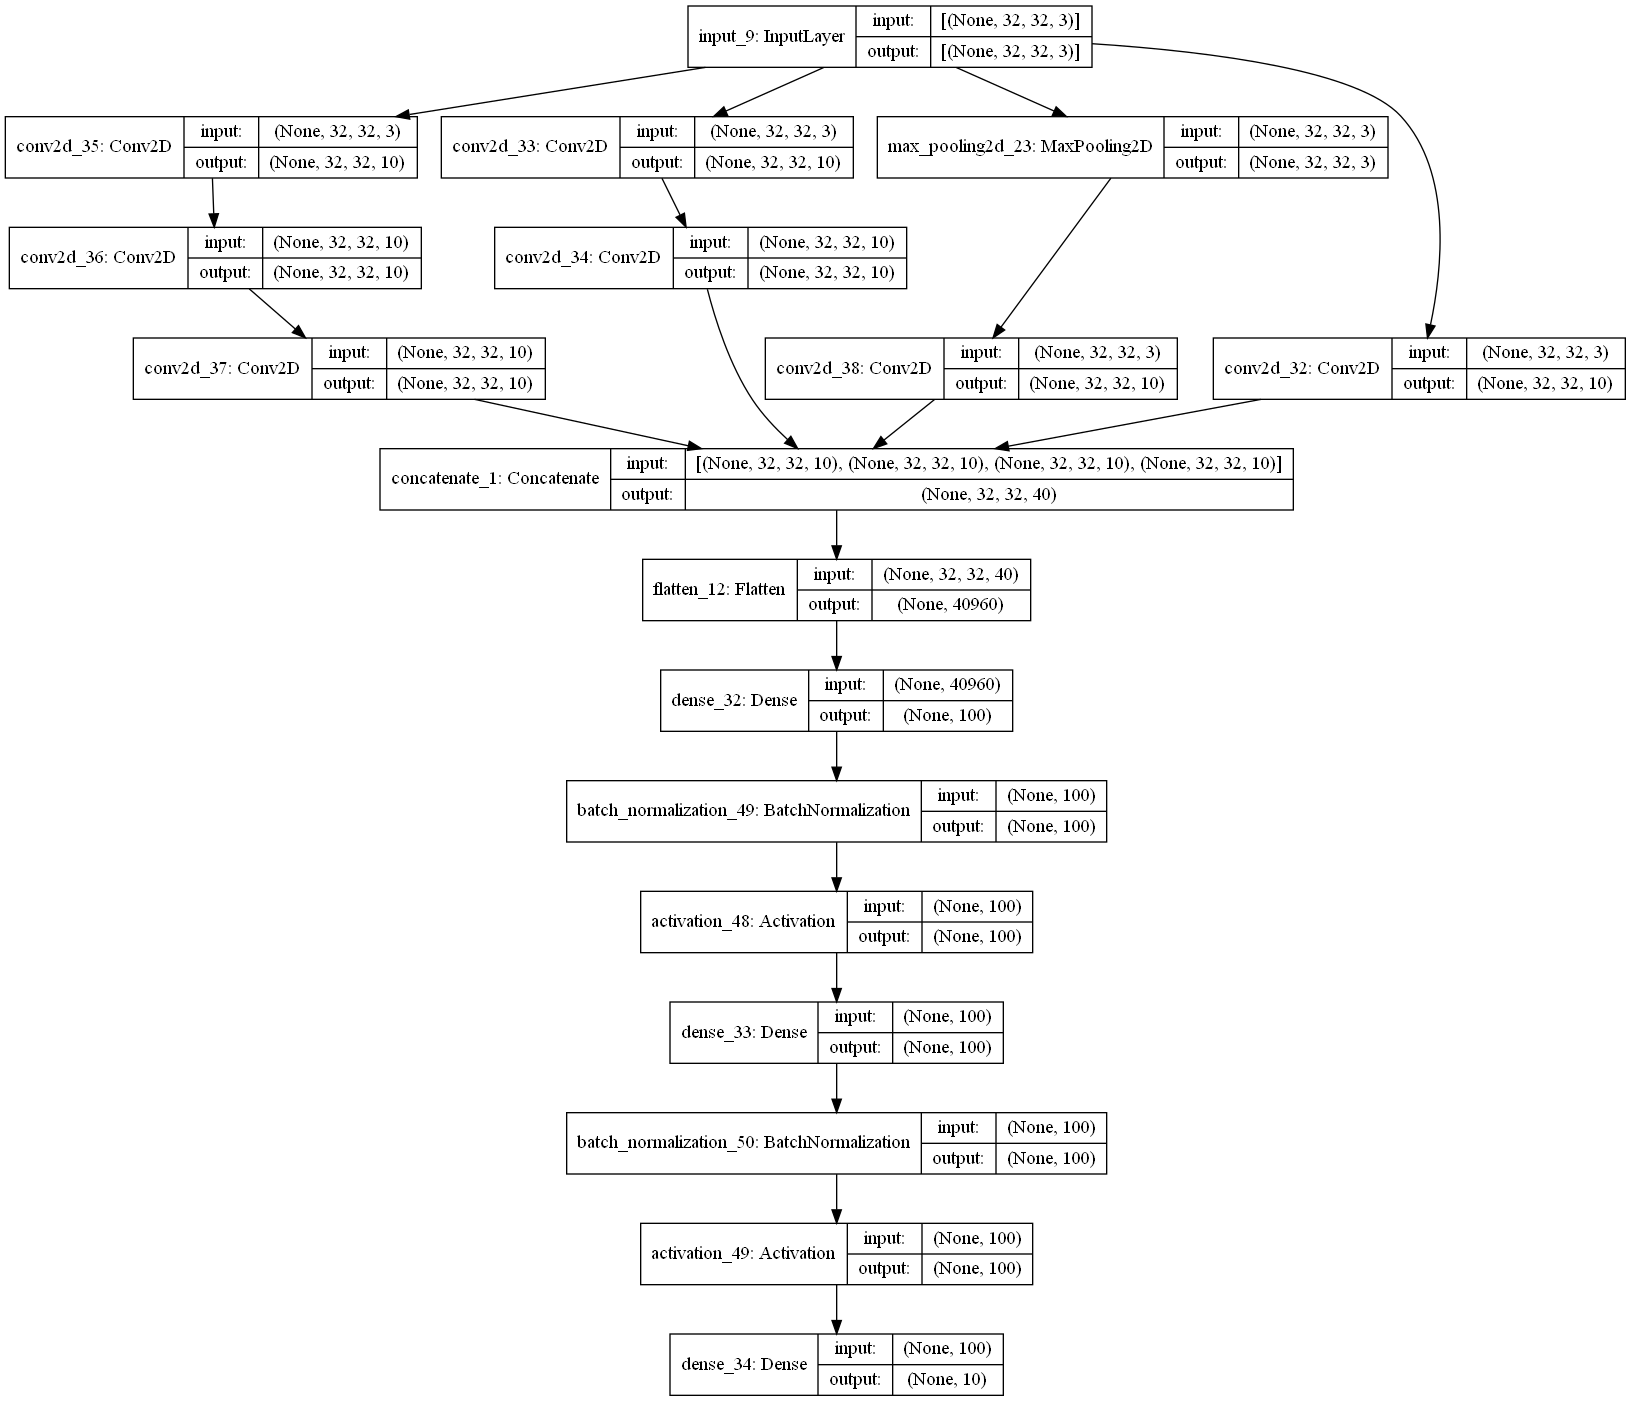

In [231]:
tf.keras.utils.plot_model(model_6_inception,"inception_model_shapes.png", show_shapes=True)

In [ ]:
model_6_inception.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
                         optimizer = tf.keras.optimizers.Adam(),
                         metrics = tf.keras.metrics.sparse_categorical_accuracy)
    
    
new_callback = tf.keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/model_6_inception/' ,
        histogram_freq = 1,
        update_freq = 'epoch',
        profile_batch = 3)

history = model_6_inception.fit(X_train,y_train, batch_size = 32, epochs=7, verbose=2,
          validation_data=(X_val, y_val),
          callbacks = callbacks + [new_callback] )

make_plots( model=model_6_inception ,name='Inception module')

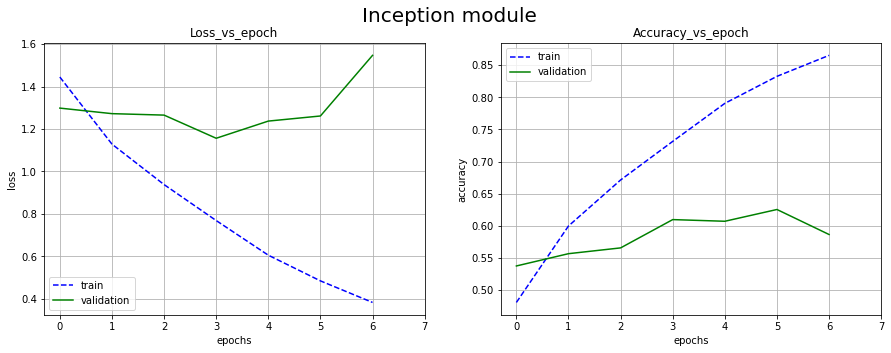

In [241]:
make_plots( model=model_6_inception ,name='Inception module')

#### Результат Inception module_10filters :
- best accuracy = .62, что очень мало при .7 у обычного двухсверточного слоя на 30 фильтров 
- обучение достигло best efficiency point на 3 эпохе
- minimum validation loss 1.2 что очень много при .9 у обычного двухсверточного слоя на 30 фильтров 

Вывод: применение необоснованно дорого.(можно добиться того же результата на двух свертках и быстрее) 

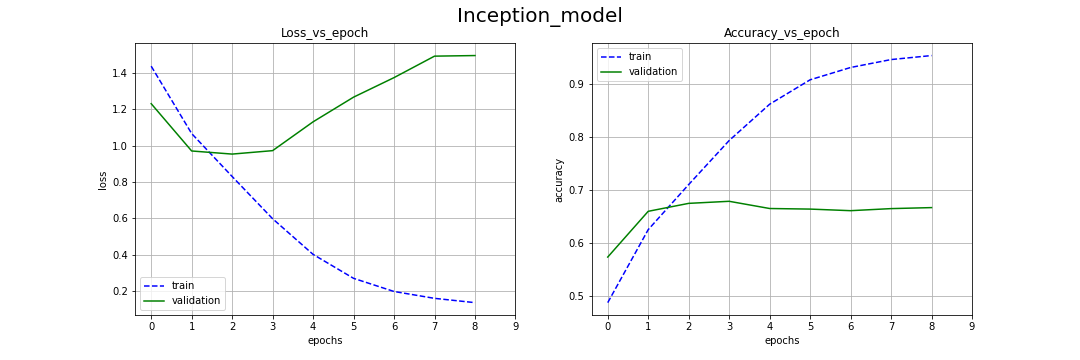

In [245]:
# тот же прогон но для 60 фильтров в модуле inception:
Image('Inception_model_60.png')

#### Результат Inception module_60filters_Normalization :
- best accuracy = .68, что все равно очень мало при .7 у обычного двухсверточного слоя на 30 фильтров 
- обучение достигло best efficiency point на 3 эпохе - очень быстро переобучается
- minimum validation loss .9 что примерно равно двум сверточным слоям на 30 фильтров 

Вывод: применение необоснованно дорого.(можно добиться того же результата на двух свертках и быстрее) 

#### ResNet with cardinality( similar to Inception Module)

In [276]:
# модель с ResNet with cardinality :

input_layer = keras.Input(shape=X_train.shape[1:])

#inception module:
#layer_1_1
#1x1 4
layer_1_1 = keras.layers.Conv2D(filters=4, kernel_size=(1,1), padding='same')(input_layer)
layer_1_1 = keras.layers.BatchNormalization()(layer_1_1)
layer_1_1 = keras.layers.Activation('relu')(layer_1_1)
#3x3 4
layer_1_1 = keras.layers.Conv2D(filters=4, kernel_size=(3,3), padding='same')(layer_1_1)
layer_1_1 = keras.layers.BatchNormalization()(layer_1_1)
layer_1_1 = keras.layers.Activation('relu')(layer_1_1)

#layer_1_2
#1x1 4
layer_1_2 = keras.layers.Conv2D(filters=4, kernel_size=(1,1), padding='same')(input_layer)
layer_1_2 = keras.layers.BatchNormalization()(layer_1_2)
layer_1_2 = keras.layers.Activation('relu')(layer_1_2)
#3x3 4
layer_1_2 = keras.layers.Conv2D(filters=4, kernel_size=(3,3), padding='same')(layer_1_2)
layer_1_2 = keras.layers.BatchNormalization()(layer_1_2)
layer_1_2 = keras.layers.Activation('relu')(layer_1_2)

#layer_1_3
#1x1 4
layer_1_3 = keras.layers.Conv2D(filters=4, kernel_size=(1,1), padding='same')(input_layer)
layer_1_3 = keras.layers.BatchNormalization()(layer_1_3)
layer_1_3 = keras.layers.Activation('relu')(layer_1_3)
#3x3 4
layer_1_3 = keras.layers.Conv2D(filters=4, kernel_size=(3,3), padding='same')(layer_1_3)
layer_1_3 = keras.layers.BatchNormalization()(layer_1_3)
layer_1_3 = keras.layers.Activation('relu')(layer_1_3)


layer_1_sum = keras.layers.concatenate( [layer_1_1, layer_1_2, layer_1_3],axis=3 )

layer_1_conv = keras.layers.Conv2D( filters=24, kernel_size=(1,1), padding='same')(layer_1_sum)
layer_1_conv = keras.layers.BatchNormalization()(layer_1_conv)
layer_1_conv = keras.layers.Activation('relu')(layer_1_conv)

#inception module:
#layer_2_1
#1x1 4
layer_2_1 = keras.layers.Conv2D(filters=4, kernel_size=(1,1), padding='same')(layer_1_conv)
layer_2_1 = keras.layers.BatchNormalization()(layer_2_1)
layer_2_1 = keras.layers.Activation('relu')(layer_2_1)
#3x3 4
layer_2_1 = keras.layers.Conv2D(filters=4, kernel_size=(3,3), padding='same')(layer_2_1)
layer_2_1 = keras.layers.BatchNormalization()(layer_2_1)
layer_2_1 = keras.layers.Activation('relu')(layer_2_1)

#layer_2_2
#1x1 4
layer_2_2 = keras.layers.Conv2D(filters=4, kernel_size=(1,1), padding='same')(layer_1_conv)
layer_2_2 = keras.layers.BatchNormalization()(layer_2_2)
layer_2_2 = keras.layers.Activation('relu')(layer_2_2)
#3x3 4
layer_2_2 = keras.layers.Conv2D(filters=4, kernel_size=(3,3), padding='same')(layer_2_2)
layer_2_2 = keras.layers.BatchNormalization()(layer_2_2)
layer_2_2 = keras.layers.Activation('relu')(layer_2_2)

#layer_2_3
#1x1 4
layer_2_3 = keras.layers.Conv2D(filters=4, kernel_size=(1,1), padding='same')(layer_1_conv)
layer_2_3 = keras.layers.BatchNormalization()(layer_2_3)
layer_2_3 = keras.layers.Activation('relu')(layer_2_3)
#3x3 4
layer_2_3 = keras.layers.Conv2D(filters=4, kernel_size=(3,3), padding='same')(layer_2_3)
layer_2_3 = keras.layers.BatchNormalization()(layer_2_3)
layer_2_3 = keras.layers.Activation('relu')(layer_2_3)


layer_2_sum = keras.layers.concatenate( [layer_2_1, layer_2_2, layer_2_3],axis=3 )

layer_2_conv = keras.layers.Conv2D( filters=24, kernel_size=(1,1), padding='same')(layer_2_sum)
layer_2_conv = keras.layers.BatchNormalization()(layer_2_conv)
layer_2_conv = keras.layers.Activation('relu')(layer_2_conv)

k=.1
layer_2_out = keras.layers.Add()([layer_2_conv,k*
                                  np.ones(shape=layer_1_conv.shape[1:], dtype=np.float16)*layer_1_conv])


# Flat
layer_3_flat = keras.layers.Flatten()(layer_2_out)

# Dense 100 ReLu
layer_4_dense_1 = keras.layers.Dense(100)(layer_3_flat)
layer_4_dense_1 = keras.layers.BatchNormalization()(layer_4_dense_1)
layer_4_dense_1 = keras.layers.Activation('relu')(layer_4_dense_1)

# Dense 100 tanh
layer_5_dense_2 = keras.layers.Dense(100)(layer_4_dense_1)
layer_5_dense_2 = keras.layers.BatchNormalization()(layer_5_dense_2)
layer_5_dense_2 = keras.layers.Activation('tanh')(layer_5_dense_2)

layer_6 = keras.layers.Dense(10,activation='sigmoid')(layer_5_dense_2)

model_6_ResNet = keras.Model(inputs = input_layer, outputs = layer_6, name = 'ResNet_model')

In [288]:
model_6_ResNet.summary()

Model: "ResNet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 32, 32, 4)    16          input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_83 (Conv2D)              (None, 32, 32, 4)    16          input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 32, 32, 4)    16          input_15[0][0]                   
_______________________________________________________________________________________

C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/7
1250/1250 - 299s - loss: 1.4647 - sparse_categorical_accuracy: 0.4735 - val_loss: 1.2849 - val_sparse_categorical_accuracy: 0.5338
Epoch 2/7
1250/1250 - 272s - loss: 1.0612 - sparse_categorical_accuracy: 0.6258 - val_loss: 1.1740 - val_sparse_categorical_accuracy: 0.5876
Epoch 3/7
1250/1250 - 262s - loss: 0.7393 - sparse_categorical_accuracy: 0.7427 - val_loss: 1.2928 - val_sparse_categorical_accuracy: 0.5704
Epoch 4/7
1250/1250 - 269s - loss: 0.4501 - sparse_categorical_accuracy: 0.8449 - val_loss: 1.4209 - val_sparse_categorical_accuracy: 0.5857
Epoch 5/7
1250/1250 - 278s - loss: 0.2813 - sparse_categorical_accuracy: 0.9030 - val_loss: 1.7044 - val_sparse_categorical_accuracy: 0.5667
Epoch 6/7
1250/1250 - 275s - loss: 0.1977 - sparse_categorical_accuracy: 0.9328 - val_loss: 1.9271 - val_sparse_categorical_accuracy: 0.5611


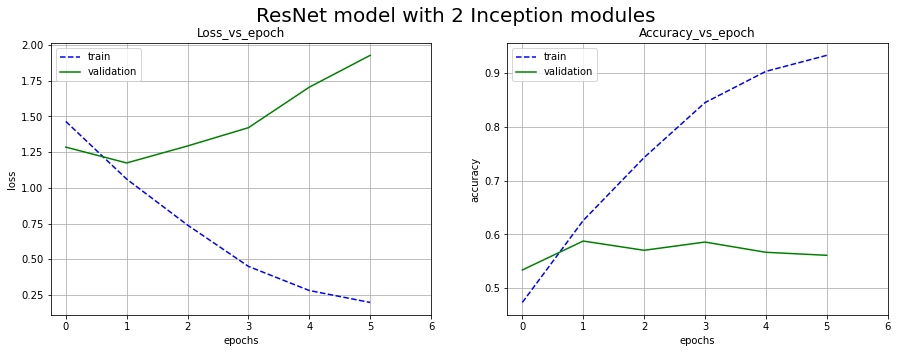

In [278]:
model_6_ResNet.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
                         optimizer = tf.keras.optimizers.Adam(),
                         metrics = tf.keras.metrics.sparse_categorical_accuracy)
    
    
new_callback = tf.keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/model_6_ResNet/' ,
        histogram_freq = 1,
        update_freq = 'epoch',
        profile_batch = 3)

history = model_6_ResNet.fit(X_train,y_train, batch_size = 32, epochs=7, verbose=2,
          validation_data=(X_val, y_val),
          callbacks = callbacks + [new_callback] )

make_plots( model=model_6_ResNet ,name='ResNet model with 2 Inception modules')

#### Результаты по ResNet with 2 Interception modules each 3 element: коэф. передачи между слоями k=0.1
- модель очень долого обучается,
- быстро переобучилась
- min validation loss = 1.1 (много, для двухсверточной модели .9)
- max validation accuracy = .59 (мало, для двухсверточной модели .7)

Вывод: применение необосновано. слишком дорого обучать - результат не оправдан.

### Увеличим количество сверточных слоев. Модель с 3 слоями по 30 фильтров. 

In [280]:
# модель с 3 слоями по 30 фильтров :
model_6 = keras.Sequential([
    #1st Conv2D
    keras.layers.Conv2D(
        filters = 30,
        kernel_size=(3, 3),
        padding='same',
        input_shape=X_train.shape[1:]),    
    keras.layers.BatchNormalization(), #Добавим нормализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    
    #2nd Conv2D
    keras.layers.Conv2D(
        filters = 30,
        kernel_size=(3, 3),
        padding='same'), 
    keras.layers.BatchNormalization(), #Добавим нормализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    
    #3rd Conv2D
    keras.layers.Conv2D(
        filters = 30,
        kernel_size=(3, 3),
        padding='same'), 
    keras.layers.BatchNormalization(), #Добавим нормализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    
    
    keras.layers.Flatten(),
    
    #Dense 100 Relu
    keras.layers.Dense(100), 
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('relu'), 
    
    #Dense 100 Tanh
    keras.layers.Dense(100), 
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('tanh'), 
                       
    keras.layers.Dense(10,activation='sigmoid')
])

Epoch 1/7
1250/1250 - 93s - loss: 1.3093 - sparse_categorical_accuracy: 0.5317 - val_loss: 1.3601 - val_sparse_categorical_accuracy: 0.5136
Epoch 2/7
1250/1250 - 89s - loss: 0.9850 - sparse_categorical_accuracy: 0.6523 - val_loss: 0.9968 - val_sparse_categorical_accuracy: 0.6493
Epoch 3/7
1250/1250 - 100s - loss: 0.8514 - sparse_categorical_accuracy: 0.7005 - val_loss: 1.0969 - val_sparse_categorical_accuracy: 0.6288
Epoch 4/7
1250/1250 - 89s - loss: 0.7716 - sparse_categorical_accuracy: 0.7282 - val_loss: 0.9290 - val_sparse_categorical_accuracy: 0.6758
Epoch 5/7
1250/1250 - 90s - loss: 0.7019 - sparse_categorical_accuracy: 0.7545 - val_loss: 0.9429 - val_sparse_categorical_accuracy: 0.6787
Epoch 6/7
1250/1250 - 89s - loss: 0.6495 - sparse_categorical_accuracy: 0.7734 - val_loss: 0.9501 - val_sparse_categorical_accuracy: 0.6796
Epoch 7/7
1250/1250 - 90s - loss: 0.6047 - sparse_categorical_accuracy: 0.7873 - val_loss: 0.9685 - val_sparse_categorical_accuracy: 0.6777


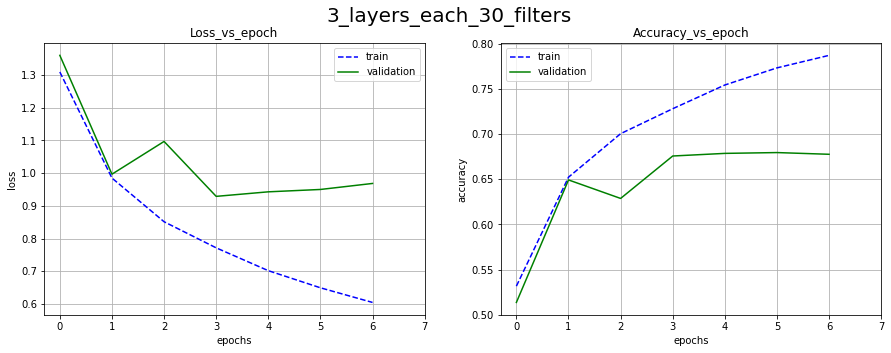

In [282]:
model_6.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
                         optimizer = tf.keras.optimizers.Adam(),
                         metrics = tf.keras.metrics.sparse_categorical_accuracy)
    
    
new_callback = tf.keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/model_6_3layers_30filters/' ,
        histogram_freq = 1,
        update_freq = 'epoch',
        profile_batch = 3)

history = model_6.fit(X_train,y_train, batch_size = 32, epochs=7, verbose=2,
          validation_data=(X_val, y_val),
          callbacks = callbacks + [new_callback] )

make_plots( model=model_6 ,name='3_layers_each_30_filters')

#### Результаты по увеличению сверточных слоев:
3 сверточных слоя(30,30,30) + 2 полносвязанных (100,100) :

- min validation loss = .9 ( для двухсверточной модели(30,30) + 2_Dense(100,100) loss такой же )
- max validation accuracy = .68 (мало, для двухсверточной модели(30,30) + 2_Dense(100,100) acurracy = .7)

Вывод:  
Так как прироста в результативности не было, а новые нейроны расходую дополнительные ресурсы при обучении - применение необосновано.

###  Увеличение количества нейронов в полносвязанных слоях:
модель с 2 слоями по 30 фильтров и 2 полносвязанных слоя (300,300):

In [283]:
# модель с 2 слоями по 30 фильтров и 2 полносвязанных слоя (300,300):
model_6_2 = keras.Sequential([
    #1st Conv2D
    keras.layers.Conv2D(
        filters = 30,
        kernel_size=(3, 3),
        padding='same',
        input_shape=X_train.shape[1:]),    
    keras.layers.BatchNormalization(), #Добавим нормализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    
    #2nd Conv2D
    keras.layers.Conv2D(
        filters = 30,
        kernel_size=(3, 3),
        padding='same'), 
    keras.layers.BatchNormalization(), #Добавим нормализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    
    keras.layers.Flatten(),
    
    #Dense 100 Relu
    keras.layers.Dense(300), 
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('relu'), 
    
    #Dense 100 Tanh
    keras.layers.Dense(300), 
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('tanh'), 
                       
    keras.layers.Dense(10,activation='sigmoid')
])

Epoch 1/7
1250/1250 - 92s - loss: 1.2588 - sparse_categorical_accuracy: 0.5526 - val_loss: 1.3070 - val_sparse_categorical_accuracy: 0.5423
Epoch 2/7
1250/1250 - 90s - loss: 0.9092 - sparse_categorical_accuracy: 0.6787 - val_loss: 1.0803 - val_sparse_categorical_accuracy: 0.6279
Epoch 3/7
1250/1250 - 90s - loss: 0.7449 - sparse_categorical_accuracy: 0.7367 - val_loss: 1.0708 - val_sparse_categorical_accuracy: 0.6399
Epoch 4/7
1250/1250 - 90s - loss: 0.6178 - sparse_categorical_accuracy: 0.7820 - val_loss: 1.5425 - val_sparse_categorical_accuracy: 0.5507
Epoch 5/7
1250/1250 - 89s - loss: 0.4993 - sparse_categorical_accuracy: 0.8235 - val_loss: 1.1465 - val_sparse_categorical_accuracy: 0.6503
Epoch 6/7
1250/1250 - 93s - loss: 0.3948 - sparse_categorical_accuracy: 0.8614 - val_loss: 1.0778 - val_sparse_categorical_accuracy: 0.6861
Epoch 7/7
1250/1250 - 88s - loss: 0.3240 - sparse_categorical_accuracy: 0.8852 - val_loss: 1.2401 - val_sparse_categorical_accuracy: 0.6622


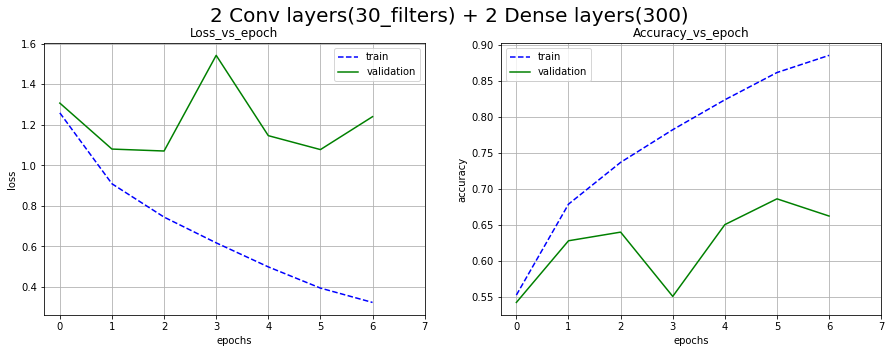

In [284]:
model_6_2.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
                         optimizer = tf.keras.optimizers.Adam(),
                         metrics = tf.keras.metrics.sparse_categorical_accuracy)
    
    
new_callback = tf.keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/model_6_2x30filters_2x300Dense/' ,
        histogram_freq = 1,
        update_freq = 'epoch',
        profile_batch = 3)

history = model_6_2.fit(X_train,y_train, batch_size = 32, epochs=7, verbose=2,
          validation_data=(X_val, y_val),
          callbacks = callbacks + [new_callback] )

make_plots( model=model_6_2 ,name='2 Conv layers(30_filters) + 2 Dense layers(300)')

#### Результаты по увеличению количества нейронов в полносвязанных слоях:
2 сверточных слоя(30,30) + 2 полносвязанных (300,300) :

- min validation loss = 1.1 (много, для двухсверточной модели + 2_Dense(100,100) loss = .9)
- max validation accuracy = .68 (мало, для двухсверточной модели + 2_Dense(100,100) acurracy = .7)

Вывод:  
Так как прироста в резулььтативности не было, а новые нейроны расходую дополнительные ресурсы при обучении - применение необосновано.

### Построим финальную модель
на базе всех лучших результатов:
- Normalization
- Dropout(min .2) в Dense слое
- datagen
- 2 свертки с 60 фильтрами

In [169]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    #featurewise_center = True, #нужно делать fit для генератора - иначе падает ядро
    #featurewise_std_normalization = True, # нужно делать fit для генератора - иначе падает ядро
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range = [0.3,1],
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range=0.5,
    channel_shift_range=0.3,
    fill_mode='nearest', # чтобы модель упала => 'wrap'
    data_format = 'channels_last')

In [297]:
# модель с 30 фильтрами :
model_7 = keras.Sequential([
    #1st Conv(3,3)+Pool(2,2) 64
    keras.layers.Conv2D(
        filters = 64,
        kernel_size=(3, 3),
        padding='same',
        input_shape=X_train.shape[1:]),
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    #2nd Conv(3,3)+Pool(2,2) 128
    keras.layers.Conv2D(
        filters = 128,
        kernel_size=(3, 3),
        padding='same'),
    keras.layers.BatchNormalization(), #Добавим нормализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    #3rd Conv(3,3)+Pool(2,2) 256
    keras.layers.Conv2D(
        filters = 256,
        kernel_size=(3, 3),
        padding='same'),
    keras.layers.BatchNormalization(), #Добавим нормализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    #4th Conv(3,3)+Pool(2,2) 512
    keras.layers.Conv2D(
        filters = 512,
        kernel_size=(3, 3),
        padding='same'),
    keras.layers.BatchNormalization(), #Добавим нормализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    #5th Conv(3,3)+Pool(2,2) 512
    keras.layers.Conv2D(
        filters = 512,
        kernel_size=(3, 3),
        padding='same'),
    keras.layers.BatchNormalization(), #Добавим нормализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    
    keras.layers.Flatten(),
    
    #Dense 100 Relu
    keras.layers.Dense(600),
    keras.layers.Dropout(.5),
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('relu'), 
    
    #Dense 100 Tanh
    keras.layers.Dense(200), 
    keras.layers.Dropout(.5),
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('tanh'), 
                       
    keras.layers.Dense(10,activation='sigmoid')
])

In [ ]:
model_7.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
                         optimizer = tf.keras.optimizers.Adam(),
                         metrics = tf.keras.metrics.sparse_categorical_accuracy)
    
    
callback = tf.keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/model_7/' ,
        histogram_freq = 1,
        update_freq = 'epoch',
        profile_batch = 3)

history = model_7.fit( datagen.flow(X_train,y_train,batch_size=15),
    epochs=300,
    verbose=2,
    callbacks=callback,
    validation_data=datagen.flow(X_val,y_val,batch_size=15),
    shuffle=True,
    initial_epoch=0,
    validation_freq=1,
    workers=1,
    use_multiprocessing=False)

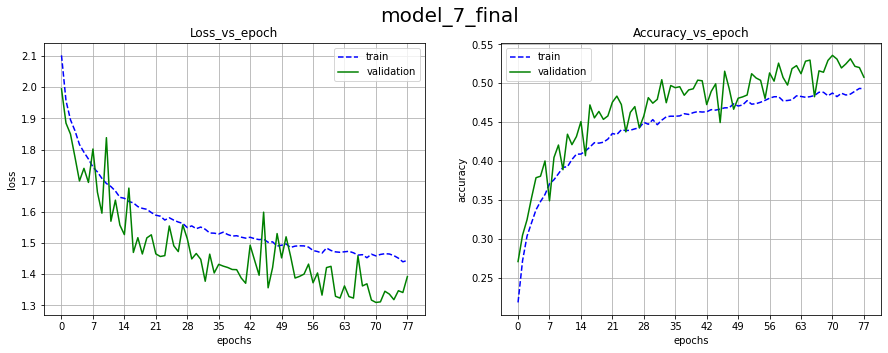

In [303]:
make_plots( model=model_7 ,name='model_7_final',save=True)

#### Выводы:
Модель очень медленно обучается, скорее всего, из-за того, что:

В datagen используется vertical flip и horizontal flip - и модели просто необходимо "видеть" все изображение, то есть receptive field должен покрывать все изображение, на данныый момент используется две свертки с 2х2 пуллингом, 
Стало быть receptive field (32х32 /2 /2 ) = 8x8.  
А нам нужно получить receptive field = 1х1, стало быть, нужно добавить 3 слоя по Conv(3,3)+Pool(2,2).  
Будет:  (8х8 /2 /2 /2) = 1x1.

Итоговая картина будет (32х32 /2 /2 /2 /2 /2) = 1х1, количество фильтров = 64, 128, 256, 512, 1024

#### Соберем финальную модель - модель с 5 свертками и фильтрами 64,128,256,512,1024

In [74]:
# модель с 5 свертками и фильтрами 64,128,256,512,1024:
model_7 = keras.Sequential([
    #1st Conv(3,3)+Pool(2,2) 64
    keras.layers.Conv2D(
        filters = 64,
        kernel_size=(3, 3),
        padding='same',
        input_shape=X_train.shape[1:]),
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    #2nd Conv(3,3)+Pool(2,2) 128
    keras.layers.Conv2D(
        filters = 128,
        kernel_size=(3, 3),
        padding='same'),
    keras.layers.BatchNormalization(), #Добавим нормализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    #3rd Conv(3,3)+Pool(2,2) 256
    keras.layers.Conv2D(
        filters = 256,
        kernel_size=(3, 3),
        padding='same'),
    keras.layers.BatchNormalization(), #Добавим нормализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    #4th Conv(3,3)+Pool(2,2) 512
    keras.layers.Conv2D(
        filters = 512,
        kernel_size=(3, 3),
        padding='same'),
    keras.layers.BatchNormalization(), #Добавим нормализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    #5th cConv(3,3)+Pool(2,2) 512
    keras.layers.Conv2D(
        filters = 512,
        kernel_size=(3, 3),
        padding='same'),
    keras.layers.BatchNormalization(), #Добавим нормализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    
    keras.layers.Flatten(),
    
    #Dense 100 Relu
    keras.layers.Dense(600),
    keras.layers.Dropout(.5),
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('relu'), 
    
    #Dense 100 Tanh
    keras.layers.Dense(200), 
    keras.layers.Dropout(.5),
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('tanh'), 
                       
    keras.layers.Dense(10,activation='softmax')
])

In [16]:
import json
json_log = open('log.json',mode='a',buffering=1)

callback = [
        tf.keras.callbacks.ModelCheckpoint(
        filepath='./saved_models/model_7.{epoch:03d}-loss_{val_loss:.2f}-acc_{val_sparse_categorical_accuracy:.3f}.h5',
        save_best_only=True,
        save_weights_only=True,
        monitor='val_sparse_categorical_accuracy',
        save_freq='epoch',
        mode='max'),
        
        tf.keras.callbacks.LambdaCallback(
        on_epoch_end = lambda epoch, logs: json_log.write(
            json.dumps( {'epoch':epoch, 'loss':logs['loss'],'val_loss':logs['val_loss'], 
                         'accuracy':logs['sparse_categorical_accuracy'],
                         'val_accuracy':logs['val_sparse_categorical_accuracy']})  + '\n'),

        on_train_end=lambda logs: json_log.close()
        )

]

In [ ]:
callback_tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/model_7/' ,
        histogram_freq = 1,
        update_freq = 'epoch',
        profile_batch = 3)

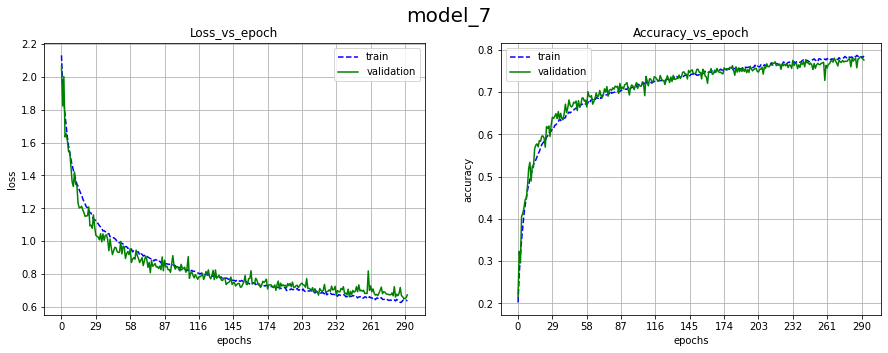

In [21]:
model_7.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
                         optimizer = tf.keras.optimizers.Adam(),
                         metrics = tf.keras.metrics.sparse_categorical_accuracy)
    

history = model_7.fit( datagen.flow(X_train,y_train,batch_size=15),
    epochs=300,
    verbose=2,
    callbacks=callback,
    validation_data=datagen.flow(X_val,y_val,batch_size=15),
    shuffle=True,
    initial_epoch=0,
    validation_freq=1,
    workers=1,
    use_multiprocessing=False)

make_plots( model=model_7 ,name='model_7',save=True)

In [76]:
model_7.load_weights('model_7.280-loss_0.65-acc_0.784.h5')

In [160]:
from sklearn.metrics import accuracy_score

y_pred = np.argmax(model_7.predict(X_val),axis=1)

val_acc = accuracy_score(y_val, y_pred )
print("\n Validation_accuracy =", val_acc)
sum(y_pred !=4)


 Validation_accuracy = 0.0933


0

Что то не то..

In [176]:
i=0
result=[]
y_pic_result = []
pic_array = []

for pic,y_pic in datagen.flow(X_val,y_val,batch_size=450):
    a = model_7.predict(pic)
    a = np.argmax(a,axis=1)
    result.append(a)
    y_pic_result.append(y_pic)
    pic_array.append(pic)
    break
    
y_pic_result = [i[0] for i in y_pic_result[0] ]
result = result[0]
#[(i,j) for i,j in zip(result,y_pic_result) if i==j ]

In [189]:
count_positive = 0
count_negative = 0

for i in range(len(result)):
    if y_pic_result[i] ==result[i]:
        count_positive +=1
    else: count_negative+=1
print('Dataset + ImageDataGenerator')        
print('Правильно угаданных {}, Неправильно угаданных {}, процент точности {:.2f}%'.format(count_positive,count_negative, count_positive/len(result)*100) )

Dataset + ImageDataGenerator
Правильно угаданных 362, Неправильно угаданных 88, процент точности 80.44%


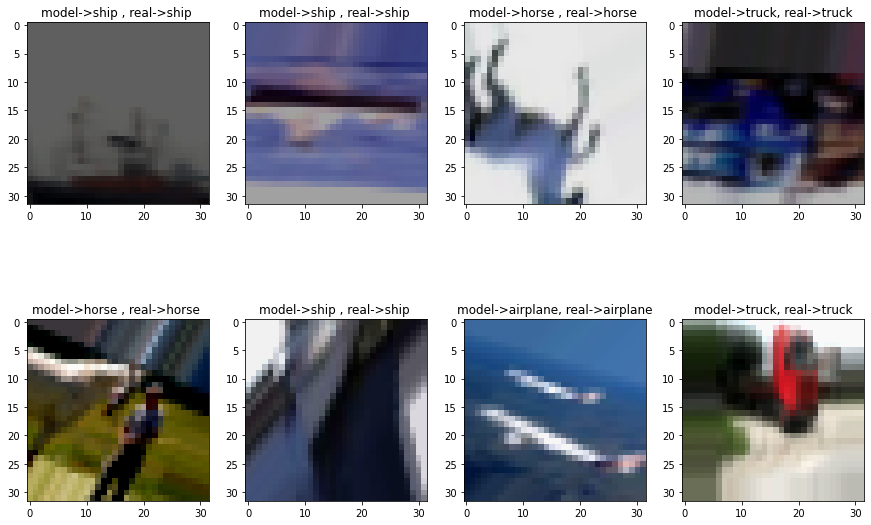

In [154]:
# проверим как предсказала модель и какое реальное изображение:
i=1
fig = plt.figure(figsize=(15,10))

for img,label in datagen.flow(X_val[:1000],y_val[:1000],batch_size=1):
    
    fig.add_subplot(240+i)
    i+=1
    
    y_pred = np.argmax(model_7.predict(img))
    plt.imshow(img[0]/255)
    plt.title('model->{}, real->{}'.format(class_names[y_pred],class_names[label[0]][0]) )
    
    if i>8: break

Дообучим модель на датасете БЕЗ ImageDataGenerator:

In [183]:
import json
json_log = open('log_2.json',mode='a',buffering=1)

callback = [
        tf.keras.callbacks.ModelCheckpoint(
        filepath='./saved_models/model_7.{epoch:03d}-loss_{val_loss:.2f}-acc_{val_sparse_categorical_accuracy:.3f}.h5',
        save_best_only=True,
        save_weights_only=True,
        monitor='val_sparse_categorical_accuracy',
        save_freq='epoch',
        mode='max'),
        
        tf.keras.callbacks.LambdaCallback(
        on_epoch_end = lambda epoch, logs: json_log.write(
            json.dumps( {'epoch':epoch, 'loss':logs['loss'],'val_loss':logs['val_loss'], 
                         'accuracy':logs['sparse_categorical_accuracy'],
                         'val_accuracy':logs['val_sparse_categorical_accuracy']})  + '\n'),

        on_train_end=lambda logs: json_log.close()
        )

]

In [185]:
model_7.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
                         optimizer = tf.keras.optimizers.Adam(),
                         metrics = tf.keras.metrics.sparse_categorical_accuracy)
    

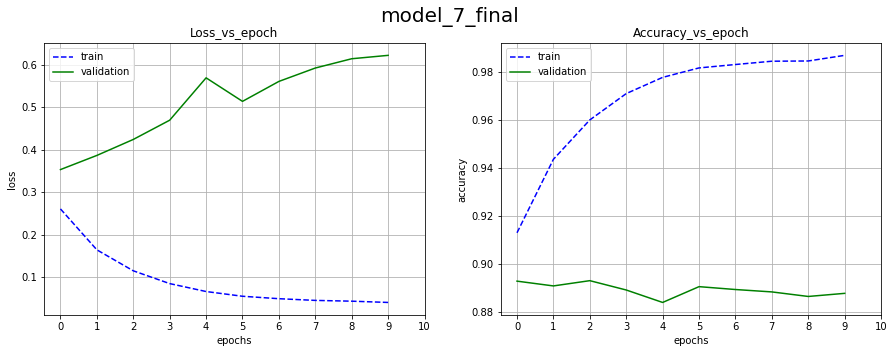

In [187]:
history = model_7.fit( X_train,y_train,batch_size=15,
    epochs=10,
    verbose=1,
    callbacks=callback,
    validation_data=(X_val,y_val),
    validation_batch_size=15,
    shuffle=True,
    initial_epoch=0,
    validation_freq=1,
    workers=-1,
    use_multiprocessing=False)

In [198]:
# модель с 5 свертками и фильтрами 64,128,256,512,1024:
model_7 = keras.Sequential([
    #1st Conv(3,3)+Pool(2,2) 64
    keras.layers.Conv2D(
        filters = 64,
        kernel_size=(3, 3),
        padding='same',
        input_shape=X_train.shape[1:]),
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    #2nd Conv(3,3)+Pool(2,2) 128
    keras.layers.Conv2D(
        filters = 128,
        kernel_size=(3, 3),
        padding='same'),
    keras.layers.BatchNormalization(), #Добавим нормализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    #3rd Conv(3,3)+Pool(2,2) 256
    keras.layers.Conv2D(
        filters = 256,
        kernel_size=(3, 3),
        padding='same'),
    keras.layers.BatchNormalization(), #Добавим нормализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    #4th Conv(3,3)+Pool(2,2) 512
    keras.layers.Conv2D(
        filters = 512,
        kernel_size=(3, 3),
        padding='same'),
    keras.layers.BatchNormalization(), #Добавим нормализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    #5th cConv(3,3)+Pool(2,2) 512
    keras.layers.Conv2D(
        filters = 512,
        kernel_size=(3, 3),
        padding='same'),
    keras.layers.BatchNormalization(), #Добавим нормализацию
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    
    keras.layers.Flatten(),
    
    #Dense 100 Relu
    keras.layers.Dense(600),
    
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('relu'), 
    
    #Dense 100 Tanh
    keras.layers.Dense(200), 
    
    keras.layers.BatchNormalization(), #Добавим норализацию
    keras.layers.Activation('tanh'), 
                       
    keras.layers.Dense(10,activation='softmax')
])

In [199]:
model_7.load_weights('./saved_models/model_7_final.h5')

In [197]:
y_pred = np.argmax(model_7.predict(X_val),axis=1)

val_acc = accuracy_score(y_val, y_pred )
print("\n Validation_accuracy =", val_acc)


 Validation_accuracy = 0.8929


Момент истины: проверьте, какого качества достигла ваша сеть.

In [192]:
from sklearn.metrics import accuracy_score

y_pred = np.argmax(model_7.predict(X_test),axis=1)

test_acc = accuracy_score(y_test, y_pred )
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.8923
Это победа!


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов. 

Самый лучший результат:
- на validation = 89.3%
- на test = 89.2%

посмотрим на classification_report:

In [204]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.93      0.89      0.91      1000
 automobile        0.91      0.96      0.94      1000
       bird        0.89      0.85      0.87      1000
        cat        0.78      0.78      0.78      1000
       deer        0.85      0.92      0.89      1000
        dog        0.82      0.82      0.82      1000
       frog        0.90      0.94      0.92      1000
      horse        0.95      0.90      0.92      1000
       ship        0.95      0.95      0.95      1000
       truck       0.95      0.91      0.93      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



Точнее всех(найдет все True) precision модель определяет:  
* horse, ship, truck __precision = 95%__

Лучше всех отловит (recall):
* automobile, ship, frog __recall = 94%__

Лучше всего модель определит (f1 критерий Фишера):
* automobile, ship __f1-score = 94%__